# Init Tdx 

In [102]:
# import logging
import sys

# stdout=sys.stdout
sys.path.append('../../')
import os
import random
import time

import matplotlib
import matplotlib.pyplot as plt
import mplfinance as mpf
# pip install --upgrade mplfinance
# sys.stdout=stdout
import numpy as np
# import numpy as np
import pandas as pd
from JohnsonUtil import commonTips as cct
from JohnsonUtil import johnson_cons as ct
from JSONData import sina_data
from JSONData import tdx_data_Day as tdd
from mplfinance.original_flavor import candlestick_ohlc

# from JSONData import tdx_hdf5_api as h5a

%matplotlib widget
plt.rc('font', family='SimHei', size=13)
matplotlib.get_backend()
# jupyter nbextension enable --py widgetsnbextension

os.environ['NUMEXPR_MAX_THREADS'] = '12'
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"
import nest_asyncio

nest_asyncio.apply()

'module://ipympl.backend_nbagg'

In [103]:
# code_list = sina_data.Sina().all.index.tolist()
# print(f'code_list:{len(code_list)}')
# df = tdd.search_Tdx_multi_data_duration('tdx_all_df_300', 'all_300', df=None,code_l=code_list, start=20170101, end=None,freq=None, col=None, index='date')

In [104]:
block_path = tdd.get_tdx_dir_blocknew() + '060.blk'

## 功能定义DEF

### ra_diff


In [105]:
def ra_diff(df):
    df['ra_diff'] = df.close.apply(lambda x: round(x / df.close.min(), 2))
    return df

### bullish 测算

In [106]:
import numpy as np


def calculate_slope(data):
    # Calculate the slope of the line that connects two points
    slope = round((data[1] - data[0]) / (1), 2)
    return slope


def detect_bull_bear(price_data, window=10):
    # Calculate the slopes of the price data for the last `window` days
    slopes = []
    for i in range(len(price_data) - window, len(price_data) - 1):
        slope = calculate_slope([price_data[i], price_data[i + 1]])
        # print(slope)
        slopes.append(slope)

    # Compare the current slope with the average slope of the last `window` days
    avg_slope = round(np.mean(slopes), 2)
    curr_slope = calculate_slope([price_data[-window], price_data[-1]])
    print(len(slopes), avg_slope, curr_slope)

    if curr_slope > avg_slope:
        # return "Bullish"
        return "Bull"
    else:
        return "Bear"


def detect_bull_bear_apply(price_data, window=10):
    # Calculate the slopes of the price data for the last `window` days
    slopes = []
    # try:
    if len(price_data) > 20:
        for i in range(len(price_data) - window, len(price_data) - 1):
            slope = calculate_slope([price_data[i], price_data[i + 1]])
            # print(slope)
            slopes.append(slope)

        # Compare the current slope with the average slope of the last `window` days
        avg_slope = round(np.mean(slopes), 2)
        curr_slope = calculate_slope([price_data[-window], price_data[-1]])
        # print(len(slopes), avg_slope, curr_slope)

        # if curr_slope > avg_slope:
        #     # return "Bullish"
        #     return "Bull"
        # else:
        #     return "Bear"
        return curr_slope
    else:
        return round((price_data[-1] - price_data[0]) / (1), 2)


code = '601360'
# Example usage
# price_data = [100, 95, 97, 99, 102, 105, 108, 111,1]
dfc = tdd.get_tdx_Exp_day_to_df(
    code, dl=60, resample='d').sort_index(
    ascending=True).reset_index()
# dfc = get_sina_data_cname(dfc)
price_data = dfc.close.values.tolist()
price_data[1], dfc.date[0]
price_data[-1], dfc.date[-1:]
print(detect_bull_bear(price_data))
print(detect_bull_bear_apply(price_data))

# Output: "Bullish"

(9.79, '2025-06-20')

(10.7,
 58    2025-09-10
 Name: date, dtype: object)

9 -0.12 -1.08
Bear
-1.08


### regression_line(X, Y)
regression_ratio(df, window=10):

9.99 0.02
Above
0.02


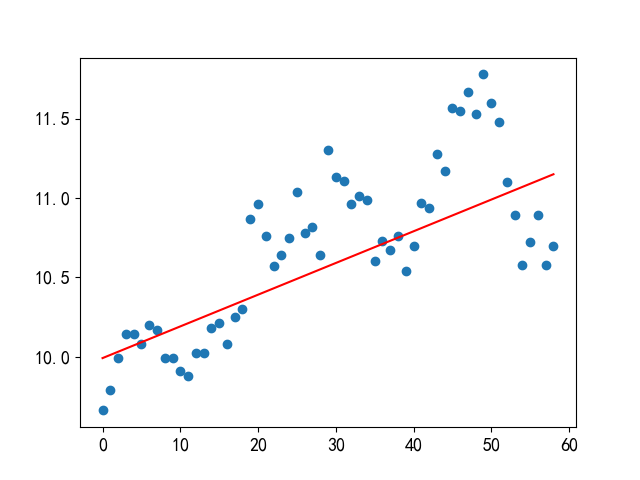

In [107]:


def regression_line(X, Y, limit=10,showall=False):
    # Calculate the coefficients of the regression line
    if not showall:
        X = X[-limit:]
        Y = Y[-limit:]
    n = len(X)
    sum_x = np.sum(X)
    sum_y = np.sum(Y)
    sum_xy = np.sum(X * Y)
    sum_xx = np.sum(X * X)
    a = round((sum_y * sum_xx - sum_x * sum_xy) / (n * sum_xx - sum_x * sum_x), 2)
    b = round((n * sum_xy - sum_x * sum_y) / (n * sum_xx - sum_x * sum_x), 2)
    return a, b


def regression_ratio(df, window=10):
    # Calculate the coefficients of the regression line
    if isinstance(df, pd.Series):
        # Y = df.values[-window:]
        # X = df.reset_index().index[-window:]
        Y = df.values
        X = df.reset_index().index
    else:
        if 'close' in df.columns:
            df = df.reset_index()
            # X = df.index[-limit:]
            # Y = df.close[-limit:]
            X = df.index
            Y = df.close
        else:
            # Y = df.values[-limit:]
            # X = df.reset_index().index[-limit:]
            Y = df.values
            X = df.reset_index().index
            
    n = len(X)
    sum_x = np.sum(X)
    sum_y = np.sum(Y)
    sum_xy = np.sum(X * Y)
    sum_xx = np.sum(X * X)
    # a = round((sum_y * sum_xx - sum_x * sum_xy) / (n * sum_xx - sum_x * sum_x),2)
    b = round((n * sum_xy - sum_x * sum_y) / (n * sum_xx - sum_x * sum_x), 2)
    return b


def predict_price(time, a, b):
    # Predict the price using the regression line
    price = a + b * time
    return price


def plot_regression_line(X, Y, a, b):
    # Plot the regression line
    # plt.close()
    plt.scatter(X, Y)
    plt.plot(X, a + b * X, color="red")
    plt.show()


def detect_position(price, a, b, X):
    # Detect the position of the current price on the regression line
    regression_price = predict_price(X[-1], a, b)
    if price > regression_price:
        return "Above"
    elif price < regression_price:
        return "Below"
    else:
        return "On"


# Example usage
time_index = dfc.index
price = dfc.close.values
a, b = regression_line(time_index, price,showall=True)
print(a, b)
# Output: (100.0, 5.0)
print(detect_position(132, a, b, time_index))
print(regression_ratio(dfc))
plot_regression_line(time_index, price, a, b)

# print(detect_position(132, a, b, time))
# Output: "On"

9.99 0.02
Above
0.02


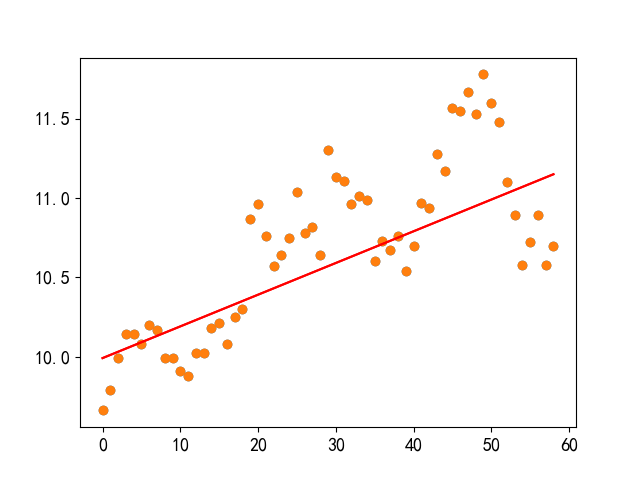

In [108]:


def regression_line(X, Y, limit=10,showall=False):
    # Calculate the coefficients of the regression line
    if not showall:
        X = X[-limit:]
        Y = Y[-limit:]
    n = len(X)
    sum_x = np.sum(X)
    sum_y = np.sum(Y)
    sum_xy = np.sum(X * Y)
    sum_xx = np.sum(X * X)
    a = round((sum_y * sum_xx - sum_x * sum_xy) / (n * sum_xx - sum_x * sum_x), 2)
    b = round((n * sum_xy - sum_x * sum_y) / (n * sum_xx - sum_x * sum_x), 2)
    return a, b


def regression_ratio(df, window=10):
    # Calculate the coefficients of the regression line
    if isinstance(df, pd.Series):
        # Y = df.values[-window:]
        # X = df.reset_index().index[-window:]
        Y = df.values
        X = df.reset_index().index
    else:
        if 'close' in df.columns:
            df = df.reset_index()
            # X = df.index[-limit:]
            # Y = df.close[-limit:]
            X = df.index
            Y = df.close
        else:
            # Y = df.values[-limit:]
            # X = df.reset_index().index[-limit:]
            Y = df.values
            X = df.reset_index().index
            
    n = len(X)
    sum_x = np.sum(X)
    sum_y = np.sum(Y)
    sum_xy = np.sum(X * Y)
    sum_xx = np.sum(X * X)
    # a = round((sum_y * sum_xx - sum_x * sum_xy) / (n * sum_xx - sum_x * sum_x),2)
    b = round((n * sum_xy - sum_x * sum_y) / (n * sum_xx - sum_x * sum_x), 2)
    return b


def predict_price(time, a, b):
    # Predict the price using the regression line
    price = a + b * time
    return price


def plot_regression_line(X, Y, a, b):
    # Plot the regression line
    # plt.close()
    plt.scatter(X, Y)
    plt.plot(X, a + b * X, color="red")
    plt.show()


def detect_position(price, a, b, X):
    # Detect the position of the current price on the regression line
    regression_price = predict_price(X[-1], a, b)
    if price > regression_price:
        return "Above"
    elif price < regression_price:
        return "Below"
    else:
        return "On"


# Example usage
time_index = dfc.index
price = dfc.close.values
a, b = regression_line(time_index, price,showall=True)
print(a, b)
# Output: (100.0, 5.0)
print(detect_position(132, a, b, time_index))
print(regression_ratio(dfc))
plot_regression_line(time_index, price, a, b)

# print(detect_position(132, a, b, time))
# Output: "On"

In [109]:
dfc.columns

Index(['date', 'code', 'open', 'high', 'low', 'close', 'vol', 'amount',
       'lower', 'ene',
       ...
       'max10', 'hmax', 'hmaxvol', 'hmax60', 'high4', 'llowvol', 'low10',
       'low60', 'low4', 'lastdu4'],
      dtype='object', length=176)

### check_postion_vol_price

In [110]:
from sklearn.linear_model import LinearRegression


def check_postion_vol_price(df):
    # 加载数据
    # df = pd.read_csv("data.csv")

    # 创建输入数据
    X = df[["close", "vol"]].values
    y = df["close"].values

    # 训练回归模型
    reg = LinearRegression().fit(X, y)

    # 计算斜率和截距
    slope = reg.coef_[0]
    intercept = reg.intercept_

    # 计算上轨和下轨
    upper_band = slope * df["close"] + intercept + 2 * df["vol"]
    lower_band = slope * df["close"] + intercept - 2 * df["vol"]

    # 判断价格是否在通道内
    df["Positon"] = np.where(
        df["close"] > upper_band, "Long", np.where(
            df["close"] < lower_band, "Short", "Neutral"))
    return df


dfc = check_postion_vol_price(dfc)
dfc[-1:]

date    code   open   high    low  close         vol       amount  \
58  2025-09-10  601360  10.59  10.85  10.56   10.7  90584812.0  970190912.0   

    lower   ene  ...   hmax      hmaxvol  hmax60  high4     llowvol  low10  \
58   10.3  11.1  ...  11.78  542110592.0   11.04  10.89  82503528.0  10.58   

    low60   low4  lastdu4  Positon  
58   9.66  10.41      2.7  Neutral  

[1 rows x 177 columns]

In [111]:

# dfc=  dfc.rename(columns={'date': 'Date', "open":"Open","high":"High","low": "Low","close":"Close"})
dfc.columns
# dfc[["Date", "Open", "High", "Low", "Close"]][-2:]
dfc.date[:3]
dfc.date = pd.to_datetime(dfc.date)
# dfc.set_index('date')
dfc.date[-1:]

Index(['date', 'code', 'open', 'high', 'low', 'close', 'vol', 'amount',
       'lower', 'ene',
       ...
       'hmax', 'hmaxvol', 'hmax60', 'high4', 'llowvol', 'low10', 'low60',
       'low4', 'lastdu4', 'Positon'],
      dtype='object', length=177)

0    2025-06-20
1    2025-06-23
2    2025-06-24
Name: date, dtype: object

58   2025-09-10
Name: date, dtype: datetime64[ns]

### show_ohlc_upper 

xratio:0.02 
code: 601360


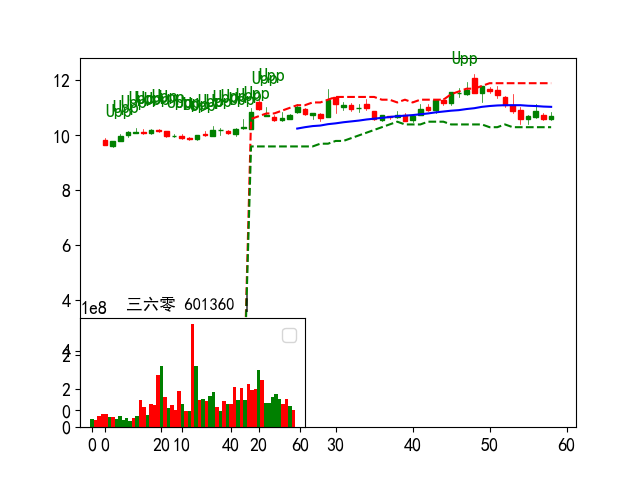

In [112]:

def show_ohlc_upper(df, code=None, allshow=True):
    # 加载数据
    # df = pd.read_csv("data.csv")
    # plt.close()
    # 计算OHLC数据
    # df = df.rename(columns={'date': 'Date', "open": "Open",
    #                "high": "High", "low": "Low", "close": "Close"})
    # df.Date = df.Date.apply(lambda x:str(x).replace('-',''))
    if 'name' not in df.columns and code is not None:
        df['name']= tdd.get_sina_data_code(code)
    if allshow:
        if 'ra_diff' in df.columns:
            print("xratio:%s ra_diff:%s" % (regression_ratio(df),df.ra_diff[-1]))
        else:
            print("xratio:%s " % (regression_ratio(df)))
    # df=df[df.upper > 0]
    df = df.rename(columns={'vol': 'volume'})
    df = df.reset_index()
    # df.date = pd.to_datetime(df.index)
    df.date = df.index
    # print(df.Date)
    # ohlc = df[["Date", "Open", "High", "Low", "Close"]].values
    ohlc = df[["date", "open", "high", "low", "close", 'volume']].values

    # 计算上轨和下轨
    # upper_band = df[df.upper != 0].upper
    # lower_band = df[df.lower != 0].lower
    upper_band = df.upper
    lower_band = df.lower
    
    # print(lower_band,df.lower)
    # print(upper_band,df.upper)

    if 'ma20d' in df.columns:
        ma20d = df[df.ma20d > 0].ma20d
    elif 'ma20' in df.columns:
        ma20d = df[df.ma20 > 0].ma20
    else:
        print('not ma20 ma20d')
    idx = len(df) - len(upper_band)
    idx2 = len(df) - len(lower_band)
    if idx != idx2:
        print(idx, len(df), len(upper_band))
        print(idx2, len(lower_band))

    # 计算当前价格的位置
    position = ['' for i in range(len(df))]
    # print(idx,len(df) ,len(upper_band),position)
    
        # else:
            # position[i] = 'Middle Band'
    # print(position)
    # 绘制OHLC图
    fig, ax = plt.subplots()
    candlestick_ohlc(ax, ohlc, width=0.6, colorup='g', colordown='r')

    # 添加上轨和下轨
    
    for i in range(idx, len(upper_band), 1):
        # print(df["close"][i])
        # print(upper_band[i],df["low"][i])
        # print(i,lower_band[i])
        #error upper_band ==0.0
        if df["close"][i] > upper_band[i]:
            position[i] = 'Upp'
        elif df["low"][i] < lower_band[i]:
            position[i] = 'Low'
            
    plt.plot(upper_band.index, upper_band, 'r--', label='Upper Band')
    plt.plot(lower_band.index, lower_band, 'g--', label='Lower Band')
    
    plt.plot(ma20d.index, ma20d, 'b', label='ma20')

    if 'hat' in df.columns:
        plt.plot(df.hat.index, df.hat, 'g', label='hat')
    # 添加位置
    for i, txt in enumerate(position):
        if txt == 'Low':
            plt.annotate(txt, (df["date"][i], df["close"][i]), xytext=(
                0, -30), textcoords='offset points', color='g')
        else:
            plt.annotate(txt, (df["date"][i], df["close"][i]), xytext=(
                0, 20), textcoords='offset points', color='g')
    axx = fig.add_subplot(325)
    # axx.plot(df[["volume"]])
    # from matplotlib import transforms
    # pad = 0.25
    # yl = ax.get_ylim()
    # ax.set_ylim(yl[0]-(yl[1]-yl[0])*pad,yl[1])
    # axx = ax.twinx()
    # axx.set_position(transforms.Bbox([[0.125,0.1],[0.9,0.32]]))

    volume = np.asarray(df.volume)
    pos = df['open'] - df['close'] < 0
    neg = df['open'] - df['close'] >= 0
    idx = np.asarray([x for x in range(len(df.date))])
    # print len(dates),len(df),ax.get_xlim(),ax.get_xticks()
    axx.bar(idx[pos], volume[pos], color='red', width=1, align='center')
    axx.bar(idx[neg], volume[neg], color='green', width=1, align='center')

    # position = ['' for i in range(len(df))]
    # position = df.Positon
    # for i, txt in enumerate(position):
    #     plt.annotate(txt, (df["Date"][i], df["Close"][i]), xytext=(0,20), textcoords='offset points')
    # 添加图例
    plt.legend(loc='best')
    # plt.legend(["Now:%s" % df.close[-1], "Hi:%s" % df.high[-1], "Lo:%0.2f" % (asset.iat[-1]), "day:%s" %
    #             len(asset), "fib:%s" % (fib),"MA:%s"%(roll_mean_days)], fontsize=12, loc=0)
    if 'name' in df.columns:
        if 'code' in df.columns:
            plt.title(df.name.values[-1:][0] + " " + df.code[0] + " | ", fontsize=12)
        else:
            plt.title(str(df.name.values[-1:][0]) + " " + " | ", fontsize=12)

    else:
        if 'code' in df.columns:
            plt.title(" | " + df.code[0] + " | ", fontsize=12)
        else:
            if code is None:
                plt.title(" | " + " | ", fontsize=12)
            else:
                plt.title(" | " + code + " | ", fontsize=12)

    # 显示图形
    print("code:",code)
    plt.show()


show_ohlc_upper(dfc,code=dfc.code[0])

In [113]:
'code' in dfc.columns

True

### show_channel_mpl

In [114]:
dfc['position'] = 0


def show_channel_mpl_bug(df, limit=60):
    # Compute the channel
    def compute_channel(df):
        # Compute the high and low of the past n periods
        n = 20
        high = df['high'].rolling(window=n, min_periods=n).max()
        low = df['low'].rolling(window=n, min_periods=n).min()
        df['upper_channel'] = high + (high - low) * 0.5
        df['lower_channel'] = low - (high - low) * 0.5

        # Update the position based on the current price
        df['position'] = np.where(df['close'] > df['upper_channel'] * 0.66, 1,
                                  np.where(df['close'] < df['lower_channel'], -1, 0))
        # print(df['position'])

    df = df.rename(columns={'vol': 'volume'})
    # df = df.reset_index()
    if 'date' in df.columns:
        df.date = pd.to_datetime(df.date)
    else:
        df = df.reset_index()
        df.date = pd.to_datetime(df.date)
    df = df.set_index('date')
    # df.date = df.index
    df = df.loc[:, ["open", "high", "low", "close", 'volume']]
    compute_channel(df)

    # fig, ax = plt.subplots()
    # Plot the ohlc chart
    mpf.plot(df, type='candle', title='OHLC chart with channel and position',
             ylabel='Price', volume=True, mav=(10, 20),
             show_nontrading=False, ylabel_lower='Position')
    # returnfig=True)
    # for i, txt in enumerate(df.position):
    #     # print(i,txt,df.index[i], df["close"][i])
    #     if txt == 0:
    #         plt.annotate("Down", (df.index[i], df["close"][i]), xytext=(
    #             0, -30), textcoords='offset points', color='g')
    #     else:
    #         plt.annotate("UP", (df.index[i], df["close"][i]), xytext=(
    #             0, 20), textcoords='offset points', color='g')

    # axlist[0].set_yticks([-1, 0, 1])
    # axlist[2].xaxis.set_ticks(df['position'])
    # axlist[2].set_xticklabels(df['upper_channel'])
    # yticks=[-1, 0, 1], yticklabels=['Sell', 'Hold', 'Buy'],
    # overlays=[(df['upper_channel'], None), (df['lower_channel'], None)])
# show_channel_mpl(dfc)

## TDX def

In [115]:
global sina_dm
sina_dm = None


def get_sina_data_cname(df, dm=None, index=False, realtime=False):
    # index_status=False
    global sina_dm
    if dm is None:
        if sina_dm is None:
            dm = sina_data.Sina().market('all')
        else:
            dm = sina_dm.copy()

    if 'ticktime' in df.columns:
        time_l = time.mktime(dm.loc[:, 'ticktime'][-1].timetuple())
        dur = round((time.time() - time_l) / 60, 2)
        if dur > 5:
            print("timel > 5,renew dm")
            dm = sina_data.Sina().market('all')
            sina_dm = dm.copy()

    if realtime:
        print("compute percent")
        df.rename(columns={'low': 'llow',
                  'high': 'lhigh', 'open': 'lopen'}, inplace=True)
        if 'nclose' in dm.columns:
            dd = cct.combine_dataFrame(
                df, dm.loc
                [:,
                 ['nclose', 'close', 'name', 'open', 'high', 'low', 'llastp',
                  'ticktime']],
                clean=True)
        else:
            dd = cct.combine_dataFrame(
                df, dm.loc
                [:, ['close', 'name', 'open', 'high', 'low', 'llastp', 'ticktime']],
                clean=True)
        dd['perc'] = ((dd['close'] - dd['llastp']) / dd['llastp'] *
                      100).map(lambda x: round(x, 2))
        # dd = cct.combine_dataFrame(df, dm['name'])

    else:
        dd = cct.combine_dataFrame(df, dm['name'])
    # cname = sina_data.Sina().get_code_cname(code)
    return dd


def write_code_to_blk(codew, blk='060'):
    block_path = tdd.get_tdx_dir_blocknew() + '%s.blk' % (blk)
    write_blk = 'n'
    write_blk = cct.cct_raw_input("write blk [Y] or [N]:")
    if write_blk == 'y' or write_blk == 'Y':
        hdf5_wri = cct.cct_raw_input(
            "Rewrite code [Y] or append [N](defalut:N):")
        if hdf5_wri == 'y' or hdf5_wri == 'Y':
            append_status = False
        else:
            append_status = True
        if len(codew) > 3:
            cct.write_to_blocknew(block_path, codew, append_status,
                                  doubleFile=False, keep_last=0)
            ("write:%s block_path:%s" % (len(codew), block_path))
        else:
            ("write error:%s block_path:%s" % (len(codew), block_path))
    return True

def get_multiIndex_drop_last_row(df,dropline=1):

    return df.drop(level='date', labels=df.index.get_level_values('date')[-dropline])

def clean_688(df):
    df = df[(~df.index.str.contains("688"))]
    return df

def clean_sina_dm(dd):
    if (cct.get_now_time_int() > 915 and cct.get_now_time_int() < 926):
        dd = dd[dd.close > 0]
    else:
        dd = dd[dd.open > 0]
    return dd

def compute_perd_value(df, market_value=3, col="vol", col_new='volsum'):

    # if market_value == None or market_value < "2":
    #     market_value = 3
    # if market_value > 1 and len(df[ df["%s%sd" % (col, market_value)] > 2])   :
    market_value = str(market_value)
    if market_value > str(1):
        temp = df[
            df.columns[
                (df.columns >= "%s1d" % (col)) &
                (df.columns <= "%s%sd" % (col, market_value))
            ]
        ]

        df['%s%sd' % (col_new, market_value)] = temp.T.sum().apply(
            lambda x: round(x, 1))
    else:
        print("market_value <= 1,No Compute")

    return df


def show_tdx_data(df, codelist=None, market_value='3', col=None,limit=20,orderby='percent'):
    col_src = [
        "name",'percent', "couts", "date", "perc", "ra_diff","xratio", "idx", "hat", "close",
        "volsum5d", "hmax", "lmin", "perc1d", "ma20", "ma250", "nclose",
        "llow", 'vol1d', 'vol2d', 'vol3d', 'vol4d', 'vol5d', "perc%sd" %
        (market_value),
        "perc5d"]
    if df is None:
        print('df is None')
        return df
    if 'close' in df.columns:
        df = df.query('close > 0')
    if isinstance(df, pd.Series):
        col_name = [co for co in col_src if co in df.index]
        # col_name.insert(1,'date')
    else:
        col_name = [co for co in col_src if co in df.columns]

    # print(col_name)
    # if isinstance(df, pd.DataFrame) and 'name' in df.columns:
    #     columns_ = col_name
    # else:
    #     if isinstance(df, pd.Series) and 'name' in df.index:
    #         columns_ = col_name.insert(1, "date")
    #     else:
    #         columns_ = col_name.remove("name")
    if orderby in df.columns:
        df=df.sort_values('percent', ascending=False)
    if isinstance(col,list):
        col_name.extend(col)
    elif col is not None:
        col_name.insert(4, col)

    if codelist is None:
        if isinstance(df, pd.Series):
            print("Count:1")
            temp = df.loc[col_name][:limit]
        else:
            print("Count:%s %s" % (df.shape))
            temp = df.loc[:, col_name][:limit]
    else:
        temp = df.loc[[x for x in codelist if x in df.index], col_name][:limit]
    return temp

def get_multi_date_duration(df, dt):
    dd = df.reset_index()
    dd = dd[dd.date >= dt]
    # dd['couts'] = dd.groupby(['code'])['code'].transform('count')
    dd = dd.set_index(['code', 'date'])
    return dd


def get_multi_code_count(df, col='code'):
    dd = df.reset_index()
    dd['couts'] = dd.groupby([col])[col].transform('count')
    dd = dd.sort_values(by=['couts', 'date'], ascending=[0, 1])
    print('count dd.couts')
    dd = dd.set_index(['code', 'date'])
    return dd


def multindex_iloc(df, index):
    label = df.index.levels[0][index]
    return df.iloc[df.index.get_loc(label)]


def get_groupby_mean_median_close(dfs):

    groupd = dfs.groupby(level=[0])

    df = groupd['close'].agg(['median', 'mean'])
    df['close'] = groupd.tail(1).reset_index().set_index(['code'])['close']
    # dfs['mean'] = groupd['close'].agg('mean')
    # dfs['median'] = groupd['close'].agg('median')

    # dfs = dfs.fillna(0)
    # idx = pd.IndexSlice
    # mask = ( (dfs['mean'] > dfs['median'])
    #         & (dfs['close'] > dfs['mean'])
    #         )
    # df=dfs.loc[idx[mask, :]]

    df = df[(df['mean'] > df['median']) & (df['close'] > df['mean'])]

    # dt_low = None
    # if dl == 1:
    #     dfs = groupd.tail(1)
    #     print("dfs tail1")
    # else:
    #     dl = 30
    #     dindex = tdd.get_tdx_Exp_day_to_df(
    #         '999999', dl=dl).sort_index(ascending=False)
    #     dt = tdd.get_duration_price_date('999999', df=dindex)
    #     dt = dindex[dindex.index >= dt].index.values
    #     dt_low = dt[-1]
    #     dtlen = len(dt) if len(dt) >0 else 1
    #     dfs = groupd.tail(dtlen)
    #     print("dfs tail:%s dt:%s"%(dtlen,dt))
    #     dfs = get_multi_date_duration(dfs,dt[-1])
    return df


def compute_df_Col_lastday(dfs, col='close', colre='perc', days=3, plus=True):
    for da in range(int(days)):
        da += 1
        if plus:
            dfs['%s%sd' % (colre, da)] = round(
                (dfs[col] - dfs[col].shift(da)) / dfs[col].shift(da) * 100, 2)
        else:
            if da == 1:
                dfs['%s%sd' % (colre, da)] = round(
                    (dfs[col] - dfs[col].shift(da)) / dfs[col].shift(da) * 100, 2)
            else:
                dfs['%s%sd' % (colre, da)] = round(
                    (dfs[col].shift(da - 1) - dfs[col].shift(da)) / dfs[col].shift(da) * 100, 2)
    return dfs

In [116]:
def get_roll_mean_all(
        single=True, tdx=False, app=True, duration=100, ma_250_l=1.3,
        ma_250_h=1.3, resample='d'):
    time_s = time.time()
    if not app and cct.get_file_size(block_path) > 100 and cct.creation_date_duration(block_path) == 0:
        print("It's Today Update")
        return True
    code_list = sina_data.Sina().all.index.tolist()
#     .Sina().all.index.tolist()
    code_list.extend(['999999', '399001', '399006'])
    print("all code:", len(code_list))
    if duration < 300:
        h5_fname = 'tdx_all_df' + '_' + str(300)
        h5_table = 'all' + '_' + str(300)
    else:
        h5_fname = 'tdx_all_df' + '_' + str(900)
        h5_table = 'all' + '_' + str(900)
    print(f'h5_fname:{h5_fname} h5_table:{h5_table}')
#     df = tdd.search_Tdx_multi_data_duration('tdx_all_df_300', 'all_300', df=None,code_l=code_list, start='20170501', end=None, freq=None, col=None, index='date')
#     df = tdd.search_Tdx_multi_data_duration(h5_fname, h5_table, df=None, code_l=code_list, start=None, end=None,
#         freq=None, col=None, index='date')
    df = tdd.search_Tdx_multi_data_duration('tdx_all_df_300', 'all_300', df=None,code_l=code_list, start=20170101, end=None,freq=None, col=None, index='date')
    # df = tdd.search_Tdx_multi_data_duration(h5_fname, h5_table, df=None,code_l=code_list, start=None, end=None, freq=None, col=None, index='date',tail=1)
    print(f'df:{df}')
    code_uniquelist = df.index.get_level_values('code').unique()

    code_select = code_uniquelist[random.randint(0, len(code_uniquelist) - 1)]
    print(round(time.time() - time_s, 2), df.index.get_level_values(
        'code').unique().shape, code_select, df.loc[code_select].shape)
    # df.groupby(level=[0]),df.index.get_level_values(0)
    # len(df.index.get_level_values('code').unique())
    # df = df[~df.index.duplicated(keep='first')]

    # multiIndex_func = {'close': 'mean', 'low': 'min', 'high': 'max', 'volume': 'sum', 'open': 'first'}
    # cct.using_Grouper(df, freq='W', col={'close': 'last'})
    # *** TypeError: Only valid with DatetimeIndex, TimedeltaIndex or PeriodIndex, but got an instance of 'Index'
    # roll_dl = duration
    if resample != 'd':

        print("resample:%s"%(resample.upper()))
        df = df.groupby(level=0).resample(resample, level=1).last()
        df = df.dropna()
        
    ''' 
    if resample != 'd':
        print("resample:%s" % (resample.upper()))
        # ohlc_dict = {'volume': 'sum','high': 'max','low': 'min','close': 'last'}
        # {'low': 'min', 'close':'mean'}
        # df = df.groupby(level=0).resample(resample, level=1).agg({'close':'last'})
        # df = df.loc[:, ['open','close', 'low', 'high']].groupby(level=0).resample(resample, level=1).agg({'close':'last'})
        df = df.loc[:, ['close']].groupby(level=0).resample(
            resample, level=1).agg({'close': 'last'}).dropna()

        df = df.dropna()
        # df = df.loc[:, ['open','close', 'low', 'high']].groupby(level=0).resample(resample, level=1, how={'low': 'min', 'close':'mean'})
        # df = df.loc[:, ['open','close', 'low', 'high']].groupby(pd.Grouper(freq=resample)).transform(np.cumsum).resample(resample, how='ohlc')

        # df = df.loc[:, ['open','close', 'low', 'high']].groupby(pd.TimeGrouper(resample)).transform(np.cumsum).resample(resample, how='ohlc')
        # r1 = len(df.loc['000001'])
        # r2 = len(df.loc['999999'])
        # roll_dl = r1 if r1 < r2 else r2

        # df['upper'] = map(lambda x: round((1 + 11.0 / 100) * x, 1), df.ma10d)
        # df['lower'] = map(lambda x: round((1 - 9.0 / 100) * x, 1), df.ma10d)
        # df['ene'] = map(lambda x, y: round((x + y) / 2, 1), df.upper, df.lower)
        # dfs['amount%d'%cumdays] = groupd['amount'].apply(pd.rolling_mean, cumdays)
    # df.ix[df.index.levels[0]]
    # df.ix[df.index[len(df.index)-1][0]] #last row
    # dfs = tdd.search_Tdx_multi_data_duration(df=dfs,code_l=code_list, start='20170918', end='20170918', freq=None, col=None, index='date')

    # print dfs[:1],len(dfs)
    # groupd.agg({'low': 'min'})
    #  idx mask filter 
    # h5a.write_hdf_db('all300', df, table='roll200', index=False,baseCount=500, append=False, MultiIndex=MultiIndex)
    '''

    df = df.reset_index().sort_values(by=['code', 'date'], ascending=[0, 1]).set_index(['code', 'date'])
    print("use time:%s" % (round(time.time() - time_s, 2)))
    return df

# 读取数据 TDX Days

## resample = 'D'

In [117]:
# resample = 'W-FRI'
resample = 'D'

df = get_roll_mean_all(
    single=False, tdx=True, app=True, duration=250, ma_250_l=1.2,
    ma_250_h=1.2, resample=resample)


# df= df.groupby(level=[0]).tail(1).reset_index().set_index('code')
# df_cname = tdd.get_sina_datadf_cnamedf(df.index.tolist(), df)
# df = df.reset_index().set_index(['code', 'date'])

lastb:2.7 all code: 5200
h5_fname:tdx_all_df_300 h5_table:all_300
df:                      open     high      low    close          vol  \
code   date                                                          
999999 2023-11-02  3028.00  3038.00  3010.00  3010.00  268794592.0   
       2023-11-03  3012.00  3040.00  3012.00  3030.00  268486336.0   
       2023-11-06  3048.00  3058.00  3038.00  3058.00  372949632.0   
       2023-11-07  3052.00  3064.00  3042.00  3058.00  326853440.0   
       2023-11-08  3052.00  3062.00  3038.00  3052.00  335677824.0   
...                    ...      ...      ...      ...          ...   
301231 2025-09-10    24.73    25.44    24.73    25.12    2178516.0   
300014 2025-09-10    70.00    71.31    69.00    70.12  109163168.0   
300237 2025-09-10     3.35     3.50     3.30     3.36  166545584.0   
300033 2025-09-10   345.00   358.25   345.00   351.50    9457915.0   
300858 2025-09-10    18.91    19.42    18.50    19.20    9218239.0   

                    

In [118]:
# df.loc['399001'][-1:]
df.loc['000002'][-1:]
# df.groupby(level=[0]).tail(30).groupby(level=[0]).tail(2)
# df.groupby(level=[0]).tail(30).groupby(level=[0]).head(1)

open  high   low  close          vol       amount
date                                                         
2025-09-10  6.81  6.86  6.76   6.86  139719680.0  950570496.0

### Test InStock

In [119]:
df.loc['301083'][:2]

open   high    low  close        vol       amount
date                                                          
2023-11-02  15.78  16.22  15.50  15.50  1845500.0   29343732.0
2023-11-03  15.86  17.83  15.73  16.91  9484947.0  160420160.0

## ra_diff

In [120]:
tail_days = 60

In [121]:
df = df.groupby(level=[0]).tail(tail_days).groupby(level=[0]).apply(ra_diff)


In [122]:
# df.loc['999999'][-3:]
# df.loc['301073'].ra_diff[-3:]
df.loc['300459'].shape

(60, 7)

## X df_regression_ratio outdate
    df_idx_detect

In [123]:
# df_reg_ratio = df.groupby(level=[0])['close'].apply(regression_ratio)
# df_idx_detect = df.groupby(level=[0])['close'].apply(detect_bull_bear_apply)
# show_ohlc_upper()
# df[:10]

In [124]:
# df_idx_detect.shape, df_idx_detect.loc['000002']
# df.loc['000002'][-2:],df_reg_ratio.loc['000002']
# df.loc['688798'][-3:]

In [125]:
# df.loc['000002'][-10:]

## sina_dm

In [126]:
sina_dm = sina_data.Sina().market('all')
lastday = cct.last_tddate()
lastday,sina_dm.name[:1]
sina_dm = clean_sina_dm(sina_dm)

('2025-09-11',
 code
 301285    鸿日达
 Name: name, dtype: object)

In [127]:
cct.get_time_to_date(time.time(), format='%Y-%D %H:%M:%S')

# abc=dm.loc[:,'ticktime'][-1]
sina_dm.ticktime[-2:]
# dm.ticktime[:1]
# sina_dm.loc[:, 'ticktime'][-1]
# time.strptime(abc,format='%Y-%m-%d %H:%M:%S')
# (time.mktime(abc.timetuple()))
(time.time() - time.mktime(sina_dm.loc[:, 'ticktime'][-1].timetuple())) / 60

'2025-09/11/25 10:41:25'

code
688178   2025-09-11 10:40:50
300707   2025-09-11 10:40:48
Name: ticktime, dtype: datetime64[ns]

0.6328601996103923

### Combine ratio and idx

In [128]:
# if 'date' in df.columns:
#     print('error duplicated date col')
#     if isinstance(df,pd.MultiIndex):
#         df.drop('date', axis=1, inplace=True)
# else:
#     df = df.reset_index().set_index('code')
#     df['idx'] = df_idx_detect
#     df['xratio'] = df_reg_ratio
#     df['name'] = sina_dm.name
#     df = df.reset_index().set_index(['code', 'date'])

## 读取实时成交量数据

In [129]:
def apply_col_toint(df, col=None):
    if col is None:
        co2int = ['boll', 'op', 'ratio', 'fib', 'fibl', 'df2']
    # co2int.extend([co for co in df.columns.tolist()
    #                if co.startswith('perc') and co.endswith('d')])
        co2int.extend(['top10', 'topR'])
    else:
        co2int = col
    co2int = [inx for inx in co2int if inx in df.columns]

    for co in co2int:
        df[co] = df[co].astype(int)

    return df

def readHdf5(fpath, root=None):
    store = pd.HDFStore(fpath, "r")
    print(store.keys())
    if len(store.keys()) > 0 and root is None and store is not None:
        root = store.keys()[0].replace("/", "")
        df = store[root]
        df = apply_col_toint(df)
    else:
        df = None
    store.close()
    return df

In [130]:
# tdx_path = "G:\\tdx_last_df.h5"
# from JohnsonUtil import commonTips as cct
sina_MultiD_path = f"{cct.get_ramdisk_dir()}\\sina_MultiIndex_data.h5".replace('\\',os.sep)
print(f'sina_MultiD_path:{sina_MultiD_path}')
h5 = readHdf5(sina_MultiD_path)
print(sina_MultiD_path)
if h5 is not None:
    h5.shape
    h5code='603019'
    h5.loc[h5code][-3:]
    code_muti = '603019'
    # h5.loc[code_muti][:2]

    freq = 'D'
    # freq = '5M'
    startime = '09:25:00'
    endtime = '15:01:00'

    time_ratio = cct.get_work_time_ratio()
    time_ratio
    run_col = ['close', 'volume']
    # run_col = ['close']
    mdf = cct.get_limit_multiIndex_freq(
        h5, freq=freq.upper(),
        col=run_col, start=startime, end=endtime, code=None)
    allvol = mdf.volume.sum()
    allvol = round(allvol / 10 / 1000 / 1000,2)
    print("总量:%s 亿"%(allvol))
    mdf['vol']=mdf['volume'].apply(lambda x: round(x /1000/1000,2)) 
    mdf['amount']=(mdf.volume * mdf.close).map(lambda x: round(x/100/1000/1000, 2))
    #全局占比
    mdf['volume'] = mdf.amount.apply(
        lambda x: round(x / allvol * 100 / time_ratio, 2))
    mdf=mdf.reset_index().set_index('code')
    mdf.loc[h5code]
else:
    mdf = None

sina_MultiD_path:G:\sina_MultiIndex_data.h5
['/all_30']
G:\sina_MultiIndex_data.h5


(628837, 6)

close   high    low  llastp    volume  lastbuy
ticktime                                                           
2025-09-11 10:40:49  90.44  90.88  83.19   83.75  56873067    84.50
2025-09-11 10:40:58  90.56  90.88  83.19   83.75  57092967    84.50
2025-09-11 10:40:49  90.44  90.88  83.19   83.75  56873067    87.38

0.595

总量:6036.6 亿


ticktime    2025-09-12 00:00:00
close                 86.565455
volume                     1.37
vol                       56.87
amount                    49.23
Name: 603019, dtype: object

In [131]:
if mdf is not None:
    mdf[:2]
    mdf.loc['603019']

ticktime      close  volume    vol  amount
code                                               
000001 2025-09-12  11.737603     0.1  31.89    3.74
000002 2025-09-12   6.779174     0.1  55.20    3.74

ticktime    2025-09-12 00:00:00
close                 86.565455
volume                     1.37
vol                       56.87
amount                    49.23
Name: 603019, dtype: object

In [132]:
# h5.index.get_level_values('code')[0]
# help(h5.index.get_level_values)
if h5 is not None:
    str(h5.index.get_level_values(1)[-1])[:10]

'2025-09-11'

In [133]:
if mdf is not None and len(mdf) > 0:
    mdf.loc['000002']
else:
    print("mdf is None")

ticktime    2025-09-12 00:00:00
close                  6.779174
volume                      0.1
vol                        55.2
amount                     3.74
Name: 000002, dtype: object

###  实时成交量个股Top!!!  (重点)

In [134]:
if mdf is not None and len(mdf) > 0:
    nowdf = mdf.sort_values(by=['volume'], ascending=[0])
    # nowdf.shape, df.shape, code_idx.shape
    # top20_nd = nowdf.reset_index().loc[:, ['code', 'volume']][:20]
    top20_nd = nowdf.reset_index().loc[:, ['code', 'volume']][:20]
    top20_nd=get_sina_data_cname(top20_nd)
    # nowdf.shape,top20_nd
else:
    top20_nd = None

In [135]:
# top20_nd

In [136]:
show_tdx_data(top20_nd)
# top20_nd.columns

Count:20 2


name
code        
300476  胜宏科技
601138  工业富联
300502   新易盛
300308  中际旭创
688256   寒武纪
688041  海光信息
600276  恒瑞医药
688981  中芯国际
300274  阳光电源
603259  药明康德
300394  天孚通信
002131  利欧股份
300450  先导智能
002384  东山精密
002475  立讯精密
600111  北方稀土
603019  中科曙光
300750  宁德时代
002837   英维克
600021  上海电力

### 合并实时成交量及SinaDM

In [137]:
from JSONData import tdx_hdf5_api as h5a
def get_tdx_all_from_h5(resample='d',showtable=True):
    #sina_monitor
    # h5_fname = 'tdx_last_df'
    # resample=resample
    # if resample=='d':
    #     dl='60'
    # else:
    #     dl='200'
    # filter='y'
    # h5_table = 'low' + '_' + resample + '_' + str(dl) + '_' + filter + '_' + 'all'
    # h5 = h5a.load_hdf_db(h5_fname, table=h5_table,code_l=None, timelimit=False,showtable=showtable)
    # return h5
    h5_fname = 'tdx_last_df'
    # resample=resample
    # if resample=='d' or resample=='3d':
    #     dl='60'
    # elif  resample=='w':
    #     dl='200'
    # else:
    #     dl='300'
    if resample=='d' or resample=='3d':
        dl=ct.Resample_LABELS_Days[resample]
    elif  resample=='w':
        #200
        dl=ct.Resample_LABELS_Days[resample]
    else:
        #300
        dl=ct.Resample_LABELS_Days[resample]
    filter='y'
    h5_table = 'low' + '_' + resample + '_' + str(dl) + '_' + filter + '_' + 'all'
    h5 = h5a.load_hdf_db(h5_fname, table=h5_table,code_l=None, timelimit=False,showtable=showtable)
    if h5 is None:
        h5,tdx = tdd.get_append_lastp_to_df(sina_data.Sina().market('all'),dl=dl,resample=resample)
    return h5

In [138]:
# mdf[:1]
if mdf is not None and len(mdf) > 0:
    sinadm = cct.combine_dataFrame(sina_dm, mdf[['vol','amount']])
else:
    sinadm = sina_dm

sinadm['percent']=((sinadm['close']-sinadm['llastp'])/(sinadm['llastp'])*100).round(1)


In [139]:
h5tdx = get_tdx_all_from_h5(resample='w')
tdx_now_w = cct.combine_dataFrame(h5tdx,sinadm)

keys:['/low_3d_120_y_all', '/low_d_60_y_all', '/low_m_300_y_all', '/low_w_200_y_all']


In [140]:
if len(tdx_now_w) > 0 and tdx_now_w.lastp1d[-1] == tdx_now_w.close[-1]:
    query_sel = f'close > lastp2d and lastp2d > lastp3d and lastp3d >lastp4d and close > high4'
else:
    query_sel = f'close > lastp1d and lastp1d > lastp2d and lastp2d >lastp3d and close > high4'

In [141]:
tdx_now_w.query(f'{query_sel}')
query_sel

lopen  lhigh   llow  lastp         lvol       lamount  lower    ene  \
code                                                                          
000035   4.43   4.43   4.10   4.18  138129168.0  6.580671e+08   4.10   4.30   
000301   7.96   8.12   7.36   7.98   95447144.0  9.802099e+08   7.80   8.90   
000668   4.86   4.96   4.09   4.64    8813730.0  8.289943e+07   5.50   8.00   
000718   2.09   2.09   1.84   2.03  341513216.0  8.607818e+08   1.90   2.20   
000751   2.83   2.83   2.45   2.69  154716800.0  5.673404e+08   2.70   3.20   
...       ...    ...    ...    ...          ...           ...    ...    ...   
688778  38.50  40.09  34.47  34.62   92799984.0  7.424648e+09  27.41  48.69   
688779   4.80   4.87   4.18   4.65  413393472.0  3.104230e+09   4.10   5.50   
835185  17.91  18.84  17.50  17.92  105346288.0  3.619456e+09  16.09  23.41   
871970   5.36   5.45   5.20   5.20   35532172.0  3.922574e+08   7.70   9.40   
872808  53.91  54.50  50.59  50.59   14573585.0  1.288886e+09  37.19  64.19   

        upper  bandwidth  ...  close         nvol  lastbuy   nlow  nhigh  \
code                      ...                                              
000035   4.60      12.23  ...   5.19   70815003.0     5.15   4.86   5.07   
000301  10.00      24.09  ...  10.06    6697301.0    10.08   9.96  10.10   
000668  10.60      63.72  ...  10.26    2822100.0    10.26   9.83  10.20   
000718   2.50      26.09  ...   3.01  292719564.0     3.01   2.78   3.00   
000751   3.80      31.95  ...   3.71   28508191.0     3.71   3.63   3.72   
...       ...        ...  ...    ...          ...      ...    ...    ...   
688778  70.12      87.69  ...  86.31   14777984.0    86.75  81.00  84.38   
688779   7.00      51.56  ...   7.48   50932528.0     7.49   7.36   7.50   
835185  30.80      62.66  ...  34.81   10839158.0    34.62  33.69  34.56   
871970  11.00      35.16  ...  11.05   10912089.0    11.06  10.42  11.38   
872808  91.31      84.31  ...  99.00    4377616.0    97.12  90.00  94.50   

        nclose  nstd     vol  amount  percent  
code                                           
000035    5.02  -2.0   70.82    3.55      9.5  
000301   10.08  -2.0    6.70    0.67      0.6  
000668   10.15  -2.0    2.82    0.29      5.0  
000718    2.99  -2.0  292.72    8.74      9.9  
000751    3.69  -2.0   28.51    1.05      0.8  
...        ...   ...     ...     ...      ...  
688778   86.31  -2.0   14.78   12.76      5.1  
688779    7.51  -2.0   50.93    3.83      0.1  
835185   34.66  -2.0   10.84    3.76      0.4  
871970   11.21  -2.0   10.91    1.22      2.8  
872808   95.19  -2.0    4.38    4.17      8.7  

[206 rows x 224 columns]

'close > lastp1d and lastp1d > lastp2d and lastp2d >lastp3d and close > high4'

### tdx_last_df and Now sina!!! RealTIME

In [142]:
tdx_h5=get_tdx_all_from_h5()
tdx_now = cct.combine_dataFrame(tdx_h5,sinadm)

keys:['/low_3d_120_y_all', '/low_d_60_y_all', '/low_m_300_y_all', '/low_w_200_y_all']


In [143]:
tdx_now.shape
# tdx_now.query('close >  lastp1d  and lastl1d < ma51d and close > ma51d and lastp1d < upper and lastp1d > lastp2d and lasth1d >high4 and boll > 0 and volume < 1')
if len(tdx_now) > 0 and tdx_now.lastp1d[-1] == tdx_now.close[-1]:
    tdx_select = tdx_now.query('close > lastp2d and percent > 3')
else:
    tdx_select = tdx_now.query('close > lastp1d and percent > 3')
show_tdx_data(tdx_select,limit=10)

(5184, 224)

Count:379 224


name  percent        date   close    hmax    lmin  perc1d  nclose  \
code                                                                        
688325  赛微微电     20.0  2025-06-20   67.25   63.81   54.50    -1.1   64.00   
688335  复洁环保     20.0  2025-06-20   17.47   15.60   13.45     0.1   16.59   
300852  四会富仕     20.0  2025-06-20   44.28   39.56   31.91     1.3   43.47   
688195  腾景科技     17.2  2025-07-09   99.06   92.75   42.91    -0.9   90.31   
832662  方盛股份     16.4  2025-06-20   40.16   47.91   27.00     1.2   38.34   
688498  源杰科技     16.2  2025-06-25  389.00  397.75  212.50     1.3  377.50   
301248  杰创智能     14.5  2025-06-20   30.66   28.30   23.55    -0.1   30.08   
688593   新相微     14.4  2025-06-20   19.06   18.89   16.23     1.3   18.48   
688519  南亚新材     14.0  2025-06-20   72.75   76.31   43.34     1.2   69.00   
301123  奕东电子     13.8  2025-06-20   46.62   48.91   25.70     1.2   44.91   

          llow  perc3d  perc5d  
code                            
688325   43.25     0.1    -1.1  
688335   11.60     0.0     0.0  
300852   30.00     0.2    -1.1  
688195   40.56     1.2    -1.1  
832662   23.33     1.3    -0.1  
688498  161.00    -1.1    -1.0  
301248   22.98     1.3    -1.1  
688593   15.17     0.0    -1.1  
688519   37.25    -0.8    -1.1  
301123   21.25    -0.9     1.2

In [144]:
print(f"buy is Na:{tdx_now.query('close.isna()').index.tolist()}")
# tdx_h5.loc['301397']
# tdx_filter = tdx_now.query('low < ma5d*1.01 and close > max5 and close >hmax and percent > 1 and close > upper and boll > 1 and not code.str.contains("688")')
tdx_filter = tdx_now.query('low < ma5d*1.01 and close > max5 and close >hmax and percent > 1 and close > upper and boll > 1 and not code.str.contains("399") and not code.str.contains("999")')
# tdx_filter.loc['000021']
show_tdx_data(tdx_filter)
# show_tdx_data(tdx_select,limit=10)

buy is Na:['399006', '399001', '999999', '399005', '600399', '605255']
Count:22 224


name  percent        date   close   hmax   lmin  perc1d  nclose  \
code                                                                      
688195  腾景科技     17.2  2025-07-09   99.06  92.75  42.91    -0.9   90.31   
834765   美之高     11.0  2025-08-05   20.20  19.47  16.16     0.2   19.36   
603989  艾华集团     10.0  2025-06-20   19.59  19.48  15.90    -0.1   19.08   
002796  世嘉科技      9.2  2025-06-20   17.52  15.75  12.56     1.2   16.69   
300492  华图山鼎      8.8  2025-08-08   69.06  67.94  58.00     0.2   69.31   
600207  安彩高科      7.3  2025-06-20    5.73   5.62   4.72    -1.1    5.35   
605378  野马电池      7.1  2025-06-19   30.00  29.09  19.45    -1.0   29.30   
603308  应流股份      6.8  2025-06-20   31.23  30.88  25.59    -0.1   30.05   
688516   奥特维      5.9  2025-06-19   45.75  43.00  33.00     0.0   45.12   
688171  纬德信息      4.9  2025-07-07   51.19  48.31  34.97     1.2   50.25   
603806   福斯特      4.7  2025-06-19   16.48  16.12  13.60    -1.1   16.45   
000875  吉电股份      4.3  2025-06-20    5.78   5.53   5.12    -0.1    5.79   
688331  荣昌生物      3.5  2025-06-30  106.69  96.81  60.00     0.1  101.44   
600801  华新水泥      3.4  2025-06-19   16.94  16.28  15.02     0.0   16.75   
603949  雪龙集团      3.4  2025-06-20   20.48  19.80  18.23     1.2   20.02   
300435  中泰股份      3.4  2025-07-04   18.81  18.58  15.24    -0.1   18.73   
601099   太平洋      3.1  2025-06-20    4.95   4.79   3.97     0.0    4.94   
300243  瑞丰高材      3.1  2025-06-20   12.15  11.70  10.41     0.0   12.16   
688357  建龙微纳      2.8  2025-06-20   36.84  35.12  30.20     0.1   35.22   
002957  科瑞技术      2.3  2025-06-20   18.73  18.42  16.62     0.0   18.33   

         llow  perc3d  perc5d  
code                           
688195  40.56     1.2   -1.10  
834765  16.31    -0.9    1.20  
603989  14.33     1.2    0.00  
002796  10.96     1.2   15.60  
300492  58.66     0.0    1.10  
600207   4.42    -1.0   25.20  
605378  16.73     1.3   -1.10  
603308  21.38     0.1   -1.10  
688516  31.67    23.0   -1.10  
688171  28.59     1.2    1.20  
603806  12.28     1.2   10.30  
000875   4.97    23.3    0.00  
688331  60.25     1.3   -1.10  
600801  11.44     1.3    0.00  
603949  17.62     1.3   -0.10  
300435  14.95    24.3    0.00  
601099   3.60     1.2   32.41  
300243   9.95    23.7    0.00  
688357  25.66     1.3    0.00  
002957  15.33     1.3   -0.10

#### 新高test!!!!!!

In [145]:
# write_code_to_blk(tdx_filter.index.tolist(),'rqg')

In [146]:
sinadm.shape
sinadm.columns
# sinadm['percent']=((sinadm['close']-sinadm['llastp'])/(sinadm['llastp'])*100).round(1)
# sinadm['percent'] = sinadm['percent'].round(1)
sinadm.query('percent > 6 ')

(5181, 45)

Index(['name', 'open', 'llastp', 'now', 'trade', 'high', 'low', 'buy', 'sell',
       'volume', 'turnover', 'b1_v', 'b1', 'b2_v', 'b2', 'b3_v', 'b3', 'b4_v',
       'b4', 'b5_v', 'b5', 'a1_v', 'a1', 'a2_v', 'a2', 'a3_v', 'a3', 'a4_v',
       'a4', 'a5_v', 'a5', 'dt', 'ticktime', 'b1_vv', 'close', 'nvol', 'timel',
       'lastbuy', 'nlow', 'nhigh', 'nclose', 'nstd', 'vol', 'amount',
       'percent'],
      dtype='object')

name    open  llastp     now  trade    high     low     buy    sell  \
code                                                                          
688167  炬光科技  122.00  120.81  136.75    0.0  137.00  120.81  136.75  136.75   
601116  三江购物   15.01   14.76   16.23    0.0   16.23   15.01   16.23    0.00   
300502   新易盛  346.00  335.00  360.00    0.0  362.75  345.00  360.00  360.00   
002796  世嘉科技   15.25   16.05   17.52    0.0   17.66   14.97   17.52   17.52   
600207  安彩高科    5.31    5.34    5.73    0.0    5.87    5.14    5.72    5.73   
...      ...     ...     ...     ...    ...     ...     ...     ...     ...   
600183  生益科技   49.19   47.97   52.12    0.0   52.34   49.19   52.12   52.12   
002636  金安国纪   12.30   12.33   13.56    0.0   13.56   12.30   13.56    0.00   
300492  华图山鼎   63.69   63.50   69.06    0.0   71.50   63.69   69.06   69.06   
605398  新炬网络   35.81   32.56   35.81    0.0   35.81   35.81   35.81    0.00   
000035  中国天楹    4.86    4.74    5.19    0.0    5.20    4.86    5.18    5.19   

          volume  ...      nvol         timel  lastbuy    nlow   nhigh  \
code              ...                                                    
688167   6119921  ...   6119921  1.757559e+09   131.50  121.50  125.50   
601116  54344698  ...  54344698  1.757559e+09    16.23   15.01   16.23   
300502  40112494  ...  40112494  1.757559e+09   357.25  345.00  357.00   
002796  50697681  ...  50697681  1.757559e+09    17.41   14.97   15.55   
600207  70319747  ...  70319747  1.757559e+09     5.66    5.20    5.31   
...          ...  ...       ...           ...      ...     ...     ...   
600183  39874911  ...  39874911  1.757559e+09    51.69   49.19   51.31   
002636  21241530  ...  21241530  1.757559e+09    13.56   12.30   12.67   
300492   3080490  ...   3080490  1.757559e+09    69.38   63.69   69.38   
605398   3707000  ...   3707000  1.757559e+09    35.81   35.81   35.81   
000035  70815003  ...  70815003  1.757559e+09     5.15    4.86    5.07   

        nclose  nstd    vol  amount  percent  
code                                          
688167  126.94  -2.0   6.12    7.78     13.2  
601116   16.20  -2.0  54.34    8.81     10.0  
300502  357.75  -2.0  40.11  143.47      7.5  
002796   16.69  -2.0  50.70    8.48      9.2  
600207    5.35  -2.0  70.32    3.77      7.3  
...        ...   ...    ...     ...      ...  
600183   51.56  -2.0  39.87   20.57      8.7  
002636   13.40  -2.0  21.24    2.85     10.0  
300492   69.31  -2.0   3.08    2.14      8.8  
605398   35.81  -2.0   3.71    1.33     10.0  
000035    5.02  -2.0  70.82    3.55      9.5  

[134 rows x 45 columns]

## check HDF LastDate

In [147]:
df_tail1 = df.groupby(level=[0]).tail(1)
# df_tail1.index

#今日的code
df_tail1[df_tail1.index.get_level_values('date') == cct.get_today()].shape

#没有今日的code
df_tail1[df_tail1.index.get_level_values('date') != cct.get_today()].shape

(0, 7)

(4930, 7)

In [148]:
# df_tail1

In [149]:
df_tail1[df_tail1.index.get_level_values('date') != cct.get_today()][:1]

open    high     low   close          vol        amount  \
code   date                                                                    
999999 2025-09-10  3806.0  3826.0  3794.0  3812.0  534539840.0  8.211136e+11   

                   ra_diff  
code   date                 
999999 2025-09-10     1.13

In [150]:
# df.info()
# code_t = '600519'
# print(dfNow.loc[code_t][-3:])
# df.loc['000001'][-1:]
# dfbak = df.copy()
# df[(df.idx > df.idx.shift(1)) & (df.xratio > df.xratio.shift(1))].shape


## reindex sort date

In [151]:
# df = df.reset_index().sort_values(by=['code', 'date'], ascending=[0, 1]).set_index(['code','date'])

## 初始化参数

In [152]:
app = True
tdx = True
duration = 300
ma_250_l = 1.02
ma_250_h = 1.2

if resample.upper() == 'D' or resample.lower() == 'd':
    if duration < 300:
        rollma = ['10', '5', '20']
    else:
        rollma = ['10', '5', '20', '250']

elif resample.upper() == 'W' or resample.lower() == 'w':
    rollma = ['5', '10']
else:
    rollma = ['5', '10']
        

def init_MulitiData_Roll(df,resample='d',duration=300):
    time_s = time.time()
    dfs = df.copy()
    # dfs = df.loc['600519']
    # groupd = dfs.groupby(level=[0])
    # groupd.['close']
    # rollma = ['5','10','60','100','200']
    # rollma = ['5','10','250']
    # df.index.get_level_values('code')[0]
    if resample.upper() == 'D' or resample.lower() == 'd':
        if duration < 300:
            rollma = ['10', '5', '20']
        else:
            rollma = ['10', '5', '20', '250']

    elif resample.upper() == 'W' or resample.lower() == 'w':
        rollma = ['5', '10','20']
    else:
        rollma = ['5', '10','20']

    # rollma.extend([str(duration)])

    # import ipdb;ipdb.set_trace()
    # df.loc['300130'][:2]

    # dfs['mean'] = groupd['close'].agg('mean')
    # dfs['median'] = groupd['close'].agg('median')

    # BOLL:MA(CV,N), COLORMAGENTA;
    # UPPER:BOLL+P*STD(CV,N), COLORYELLOW;
    # LOWER:BOLL-P*STD(CV,N), COLORYELLOW;
    # df['BollUpper'] = df.close.shift(10).mean()+2*df.close.shift(10).std()
    # df['BollDown'] = df.close.shift(10).mean()-2*df.close.shift(10).std()
    for da in rollma:
        cumdays = int(da)
        dfs['ma%d' % cumdays] = round(dfs['close'].rolling(cumdays).mean(), 2)

        # dfs['upper'] = dfs['ma%d' % cumdays].apply(
        #     lambda x: round((1 + 11.0 / 100) * x, 1))
        # dfs['lower'] = dfs['ma%d' % cumdays].apply(
        #     lambda x: round((1 - 9.0 / 100) * x, 1))
        # dfs['boll'] = list(map(lambda x, y: round(
        #     (x + y) / 2, 1), dfs['upper'], dfs['lower']))
    if duration > 100:
        dfs['upper'] = round(
            dfs['close'].rolling(20).mean() + 2 *
            dfs['close'].rolling(20).std(),
            2)
        dfs['lower'] = round(
            dfs['close'].rolling(20).mean() - 2 *
            dfs['close'].rolling(20).std(),
            2)

        dfs['boll'] = round(dfs['close'].rolling(20).mean(), 2)

        dfs['hmax'] = round(dfs['high'].rolling(20).max(), 2)
        dfs['lmin'] = round(dfs['low'].rolling(20).min(), 2)

        dfs['hat'] = dfs['upper'] - dfs['lower']

        # dfs['hmax'] = round(dfs['close'].cummax(), 2)


    dfs = compute_df_Col_lastday(dfs, col='close', colre='perc', days=5)
    dfs = compute_df_Col_lastday(dfs, col='vol', colre='vol', days=5, plus=False)
    dfs = compute_perd_value(dfs, market_value=5, col='vol', col_new='volsum')

    return dfs
# dfs['perc1d'] = round(
#     (dfs['close'] - dfs['close'].shift(1)) / dfs['close'].shift(1) * 100, 2)
# dfs['perc3d'] = round(
#     (dfs['close'] - dfs['close'].shift(3)) / dfs['close'].shift(3) * 100, 2)
# dfs['perc5d'] = round(
#     (dfs['close'] - dfs['close'].shift(5)) / dfs['close'].shift(3) * 100, 2)

In [153]:
dfsRoot=init_MulitiData_Roll(df,resample=resample)

### DFS MutiIndex Test 0507

In [154]:
# dfs.loc['000002'][-5:].upper
dfsRoot.loc['603357'][-5:][['close','upper','low','boll']][-2:]
dftemp = dfsRoot.loc['603357']
dftemp[dftemp.close > dftemp.upper][:2]
print(dftemp.shape)

close  upper   low  boll
date                                
2025-09-09   8.52   9.02  8.49  8.71
2025-09-10   8.49   9.01  8.46  8.69

open  high   low  close        vol      amount  ra_diff  ma10  \
date                                                                        
2025-07-25  8.92  8.93  8.79    8.8  7449512.0  65776696.0     1.04  8.62   

             ma5  ma20  ...  perc2d  perc3d  perc4d  perc5d  vol1d  vol2d  \
date                    ...                                                 
2025-07-25  8.67  8.62  ...    2.44    1.97    0.92    1.97  86.29  -3.45   

            vol3d  vol4d  vol5d  volsum5d  
date                                       
2025-07-25  -1.52 -39.13  -8.76      33.4  

[1 rows x 28 columns]

(60, 28)


In [155]:
# dfs.loc['688027']
dfsRoot['ma51d'] = round(dfsRoot['close'].rolling(5).mean(), 2)
show_tdx_data(dfsRoot.loc['600519'][-2:],col=['ma51d','ra_diff'])
# show_tdx_data(dfs.loc['600519'])

Count:2 29


ra_diff     hat   close  volsum5d    hmax    lmin  perc1d  \
date                                                                    
2025-09-09     1.07  108.38  1505.0     -29.2  1510.0  1420.0    0.27   
2025-09-10     1.08  112.88  1522.0      30.2  1530.0  1420.0    1.13   

               ma20   ma250  vol1d  vol2d  vol3d  vol4d  vol5d  perc3d  \
date                                                                     
2025-09-09  1462.65  357.30 -30.44  37.43 -21.69   6.00 -20.54    2.17   
2025-09-10  1467.75  363.33  38.95 -30.44  37.43 -21.69   6.00    2.63   

            perc5d   ma51d  ra_diff  
date                                 
2025-09-09    0.94  1488.6     1.07  
2025-09-10    2.77  1496.8     1.08

### Append Now SinaTo MultiIndex dfNow

In [156]:
# tail_days = 60
# cct.get_today()
def get_Append_Sina_To_MultiTDX(df,sina_dm):
    if cct.get_work_time_duration():
        sina_today=sina_dm.copy()
        if not isinstance(sina_today,pd.MultiIndex) and  'date' not  in sina_today.columns:
            sina_today['date']=pd.to_datetime(cct.get_today())
            print('concat1 init:sina_today:%s'%(sina_today.index[0]))
            # df_reg_ratio2 = df.groupby(level=[0])['close'].apply(regression_ratio)
            # df_idx_detect2 = df.groupby(level=[0])['close'].apply(detect_bull_bear_apply)
            # sina_today['idx'] = df_idx_detect2
            # sina_today['xratio'] = df_reg_ratio2
            # sina_today=sina_today.loc[:,['open','high','low','close','date','idx',y'xratio']].reset_index().set_index(['code', 'date'])
            if 'vol' in sina_today.columns:
                sina_today=sina_today.loc[:,['open','high','low','close','vol','amount','name','date']].reset_index().set_index(['code', 'date'])
            else:
                sina_today=sina_today.loc[:,['open','high','low','close','date']].reset_index().set_index(['code', 'date'])

        if sina_today.index[0] not in df.index:
            # df.index=df.index.append(sina_dm.index)
            print('concat1:sina_today:%s %s'%(sina_today.index[0]))
            df = pd.concat([df, sina_today])


    #         sina_today=sina_dm.copy()
    #         #drop line and append idx
    #         if not isinstance(sina_today,pd.MultiIndex) and  'date' not  in sina_today.columns:
    #             sina_today['date']=pd.to_datetime(cct.get_today())
    #             print('concat2 init:sina_today:%s'%(sina_today.index[0]))

    #             sina_today['idx'] = df_idx_detect2
    #             sina_today['xratio'] = df_reg_ratio2
    #             sina_today=sina_today.loc[:,['open','high','low','close','date','name','idx','xratio']].reset_index().set_index(['code', 'date'])
    #             # sina_today=sina_today.loc[:,['open','high','low','close','date']].reset_index().set_index(['code', 'date'])   


    #         df = get_multiIndex_drop_last_row(df,dropline=1)

            if sina_today.index[0] not in df.index:
                # df.index=df.index.append(sina_dm.index)
                print('concat2:sina_today:%s %s'%(sina_today.index[0]))
                df = pd.concat([df, sina_today])
            df = df.reset_index().sort_values(by=['code', 'date'], ascending=[0, 1]).set_index(['code','date'])
    return df

# dfNow=get_Append_Sina_To_MultiTDX(df.groupby(level=[0]).tail(30),sina_dm)


if resample.upper() == 'D':
    dfsRoot=get_Append_Sina_To_MultiTDX(dfsRoot.groupby(level=[0]).tail(tail_days),sinadm)
    dfNow= dfsRoot.groupby(level=[0]).tail(tail_days/2)
    
    dfNow=init_MulitiData_Roll(dfNow,resample=resample,duration=20)
else:
    dfNow = dfsRoot.groupby(level=[0]).tail(tail_days/2).copy()
# df = df.reset_index().sort_values(by=['code', 'date'], ascending=[0, 1]).set_index(['code','date'])
# df[-2:]
dfNow[-2:]

concat1 init:sina_today:301285
concat1:sina_today:301285 2025-09-11 00:00:00


open   high    low  close          vol        amount  \
code   date                                                                
000001 2025-09-10  11.74  11.79  11.71  11.77  79266840.00  9.321702e+08   
       2025-09-11  11.77  11.80  11.71  11.72        31.89  3.740000e+00   

                   ra_diff   ma10    ma5   ma20  ...  perc4d  perc5d   vol1d  \
code   date                                      ...                           
000001 2025-09-10     1.01  11.84  11.74  12.00  ...    0.26    0.17   -7.89   
       2025-09-11      NaN  11.81  11.73  11.98  ...    0.00   -0.17 -100.00   

                   vol2d  vol3d  vol4d  vol5d  volsum5d  ma51d  name  
code   date                                                           
000001 2025-09-10  -6.91  12.78 -36.72  -5.26     -44.0  11.74   NaN  
       2025-09-11  -7.89  -6.91  12.78 -36.72    -138.7    NaN  平安银行  

[2 rows x 30 columns]

In [157]:
dfsRoot.groupby(level=[0]).tail(60).loc['000002'][-1:]


open  high   low  close   vol  amount  ra_diff  ma10  ma5  ma20  \
date                                                                          
2025-09-11  6.82  6.83  6.73   6.76  55.2    3.74      NaN   NaN  NaN   NaN   

            ...  perc4d  perc5d  vol1d  vol2d  vol3d  vol4d  vol5d  volsum5d  \
date        ...                                                                
2025-09-11  ...     NaN     NaN    NaN    NaN    NaN    NaN    NaN       NaN   

            ma51d  name  
date                     
2025-09-11    NaN  万 科Ａ  

[1 rows x 30 columns]

### Xratio and tail 60 MultiIndex 

In [158]:
## dfNow['xratio'] = dfNow['close'].rolling(30).apply(regression_ratio)
if 'xratio' not in dfNow.columns:
    df_xratio = dfNow.groupby(level=[0])['close'].rolling(24).apply(regression_ratio)
    df_xratio.index =df_xratio.to_frame().index.droplevel(1)
    dfNow['xratio'] = df_xratio

In [159]:
# df_xratio.loc['605589'][-8:]
dfsRoot.loc['603019'][:1]
# dfNow[-12:][-2:]

open   high    low  close         vol       amount  ra_diff  \
date                                                                       
2025-05-21  63.47  63.47  62.88  62.97  10667852.0  672254208.0     1.02   

             ma10    ma5   ma20  ...  perc4d  perc5d  vol1d  vol2d  vol3d  \
date                             ...                                        
2025-05-21  15.25  20.41  12.21  ...  554.57  553.89 -46.94  55.24   6.23   

            vol4d  vol5d  volsum5d  ma51d  name  
date                                             
2025-05-21  -8.25 -27.25     -21.0  20.41   NaN  

[1 rows x 30 columns]

## DFNow Query check

In [160]:
dfNow_A = dfNow.query('@dfNow.index.get_level_values(0) < "688000"')
# dfxra = dfNow_A.groupby(level=[0]).tail(3).query('xratio - xratio.shift(1) > (xratio.shift(1) - xratio.shift(2))*1.1')
# dfNow.groupby(level=[0]).tail(3)
lastworkday = cct.last_tddate(1)
print(lastworkday)
# dfxra.groupby(level=[0]).tail(1).query('date >= @lastworkday').xratio
# dfxra.query('@dfxra.index.get_level_values(0) < "688000"')
# dfxra.query('not @dfxra.index.get_level_values(0).str.contains("688") ')

# df.query(f'ColumnName >= {VariableName}')

# dfxra = dfNow_A.groupby(level=[0]).tail(3).query('0 > xratio > -0.08 and xratio - xratio.shift(1) > (xratio.shift(1) - xratio.shift(2))*1.1')

# dfxra = dfNow_A.groupby(level=[0]).tail(3).query('xratio > 0 and xratio.shift(1) < 0 and xratio - xratio.shift(1) > (xratio.shift(1) - xratio.shift(2))*1.1')

dfxra = dfNow_A.groupby(level=[0]).tail(3).query('high > upper  and xratio - xratio.shift(1) > (xratio.shift(1) - xratio.shift(2))')

dfxra.query('date >= @lastworkday').sort_values(by='xratio',ascending=0).xratio[:10]
# dfxra.query('date >= @lastworkday').xratio[:10]

# dfxra.query('date >= @lastworkday').loc['605589'].xratio
df_xratio.loc['605369'][-8:]

2025-09-11


Series([], Name: xratio, dtype: float64)

date
2025-09-02     NaN
2025-09-03   -0.03
2025-09-04   -0.04
2025-09-05   -0.05
2025-09-08   -0.05
2025-09-09   -0.05
2025-09-10   -0.06
2025-09-11   -0.05
Name: close, dtype: float64

In [161]:
# dfNow['idx'] = dfNow['close'].rolling(25).apply(detect_bull_bear_apply)
df_idx = dfNow.groupby(level=[0])['close'].rolling(25).apply(detect_bull_bear_apply)
df_idx.index =df_idx.to_frame().index.droplevel(1)
dfNow['idx'] = df_idx

### dfNow Top

date
2025-09-10    6.19
2025-09-11     NaN
Name: upper, dtype: float64

(60, 30)
xratio:0.0 ra_diff:nan
code: 300459


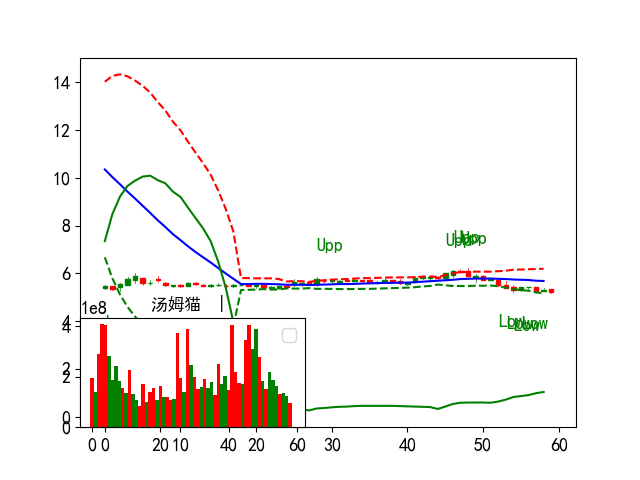

In [162]:
dfNow.loc['300459'][-2:].upper
print(dfsRoot.loc['300459'][-tail_days:].shape)
show_ohlc_upper(dfsRoot.loc['300459'][-tail_days:],code='300459')

In [163]:
# '302132' in dfsRoot.index

300476
xratio:3.22 ra_diff:nan
code: 300476


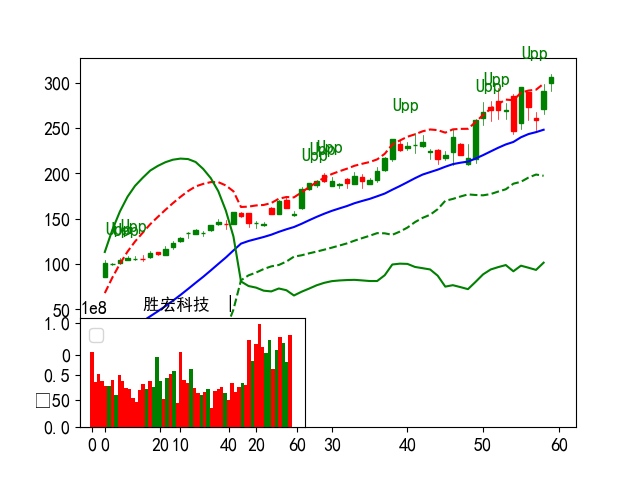

601138
xratio:0.69 ra_diff:nan
code: 601138


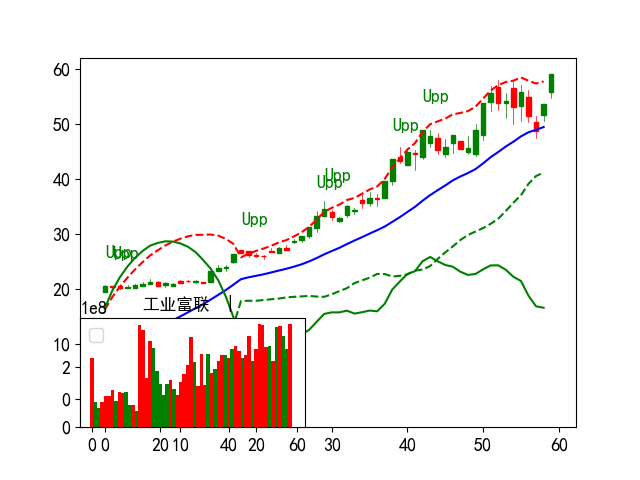

In [164]:
if top20_nd is not None:
    for co in top20_nd.index[:2]:
            print(co)
            # show_ohlc_upper(dfs.loc[co][-30:],co)
            if co in dfsRoot.index:
                show_ohlc_upper(dfsRoot.loc[co][-tail_days:],co)
            else:
                print(f'code:{co} not find in dfsRoot')

In [165]:
code_df = '600519'
dfNow_t2 = dfNow.groupby(level=[0]).tail(2)
# dfNow_f = dfNow_t2[ (dfNow_t2.idx > dfNow_t2.idx.shift(1)) & (dfNow_t2.xratio > dfNow_t2.xratio.shift(1)) ]
idx = pd.IndexSlice
mask_df =  ((dfNow_t2.idx > dfNow_t2.idx.shift(1)) & (dfNow_t2.xratio > dfNow_t2.xratio.shift(1)) )

dfNow_t2 = dfNow_t2.loc[idx[mask_df, :]]

group250 = dfNow_t2.groupby(level=[0])
dfNow_f = group250.tail(1).reset_index().set_index('code')
mask_df = (dfNow_f.date >= cct.get_today())
dfNow_f = dfNow_f.loc[idx[mask_df, :]]
dfNow_f[:2]

date    open    high     low   close    vol  amount  ra_diff  \
code                                                                        
689009 2025-09-11   66.88   67.12   65.69   66.81   5.41    3.60      NaN   
688981 2025-09-11  102.62  107.25  100.00  106.69  60.65   62.87      NaN   

          ma10     ma5  ...  vol1d  vol2d  vol3d  vol4d  vol5d  volsum5d  \
code                    ...                                                
689009   48.21   49.57  ... -100.0  -0.36  -0.37 -30.97  28.06    -103.6   
688981  104.83  109.53  ... -100.0 -33.96  -3.96 -32.25  70.13    -100.0   

        ma51d  name  xratio    idx  
code                                
689009    NaN  九号公司    0.30  19.03  
688981    NaN  中芯国际    1.03  15.63  

[2 rows x 33 columns]

In [166]:
# dfNow_f.shape,dfNow_f[:3],dfNow_t2.loc['600812'],df.loc['600812'][-2:]
# dfNow_f[dfNow_f.date >= cct.get_today()]
# dfNow_f.loc['000006']
# dfNow_t2.loc['000006']
# (dfNow_t2.loc[code_df].idx > dfNow_t2.loc[code_df].idx.shift(1)) 
# (dfNow_t2.loc[code_df].xratio > dfNow_t2.loc[code_df].xratio.shift(1))
# dfNow_f.loc[code_df],dfNow.loc[code_df]

### pandas multiinde drop last row

In [167]:
df.loc['000002'][-2:]

open  high   low  close          vol        amount  ra_diff
date                                                                   
2025-09-09  6.79  6.91  6.74   6.86  217939808.0  1.494593e+09     1.08
2025-09-10  6.81  6.86  6.76   6.86  139719680.0  9.505705e+08     1.08

In [168]:
dfNow.loc['000002'][-2:]

open  high   low  close          vol        amount  ra_diff  ma10  \
date                                                                            
2025-09-10  6.81  6.86  6.76   6.86  139719680.0  9.505705e+08     1.08  6.73   
2025-09-11  6.82  6.83  6.73   6.76         55.2  3.740000e+00      NaN  6.73   

             ma5  ma20  ...   vol1d  vol2d  vol3d  vol4d  vol5d  volsum5d  \
date                    ...                                                 
2025-09-10  6.72  6.69  ...  -35.89  -6.08  98.14 -23.82 -11.95      20.4   
2025-09-11  6.77  6.71  ... -100.00 -35.89  -6.08  98.14 -23.82     -67.7   

            ma51d  name  xratio   idx  
date                                   
2025-09-10   6.72   NaN    0.02  0.09  
2025-09-11    NaN  万 科Ａ    0.01 -0.03  

[2 rows x 32 columns]

# 基础处理

In [169]:
# show_tdx_data(dfs.loc['600519'][-2:])
dfs = dfNow.fillna(0)
groupd = dfs.groupby(level=[0])
single = False
dt_low = None
df_idx = None
if single:
    dfs_dtlen = groupd.tail(1)
    print("dfs tail1")
else:
    single = True
    dl = 30
    dindex = tdd.get_tdx_Exp_day_to_df(
        '999999', dl=dl, resample=resample).sort_index(ascending=False)
    dt = tdd.get_duration_price_date('999999', df=dindex)

    dt = dindex[dindex.index >= dt].index.values
    dt_low = dt[-1]
    print('dt_low:%s %s' % (dt_low,dt[0]))
    dtlen = len(dt) if len(dt) > 0 else 1
    dfs_dtlen = groupd.tail(dtlen)
    # import ipdb;ipdb.set_trace()
    dfs_dtlen[-2:]
    df_idx = get_groupby_mean_median_close(dfs_dtlen)

    # print(("dfs tail:%s dt:%s" % (dtlen, dt)))
    dfs_dtlen = get_multi_date_duration(dfs_dtlen, dt[-1])

# groupd2 = dfs.groupby(level=[0])
# dfs['ma%d'%cumdays] = groupd['close'].apply(pd.rolling_mean, cumdays)

# dfs.reset_index().groupby(['code'])['date'].transform('count')
# single = True

print("Low:%s" % (dt[-1]))
# dfs_dtlen.loc['999999'].reset_index().date
lastday_week = dfs_dtlen.loc['999999'].reset_index().date[0]
lastday_week
# dfs_dtlen[('ma%s') % (rollma[-1])][-2:]
# print(df_idx)

dt_low:2025-08-04 2025-09-10


open   high    low  close          vol        amount  \
code   date                                                                
000001 2025-09-10  11.74  11.79  11.71  11.77  79266840.00  9.321702e+08   
       2025-09-11  11.77  11.80  11.71  11.72        31.89  3.740000e+00   

                   ra_diff   ma10    ma5   ma20  ...   vol1d  vol2d  vol3d  \
code   date                                      ...                         
000001 2025-09-10     1.01  11.84  11.74  12.00  ...   -7.89  -6.91  12.78   
       2025-09-11     0.00  11.81  11.73  11.98  ... -100.00  -7.89  -6.91   

                   vol4d  vol5d  volsum5d  ma51d  name  xratio   idx  
code   date                                                           
000001 2025-09-10 -36.72  -5.26     -44.0  11.74     0   -0.03 -0.31  
       2025-09-11  12.78 -36.72    -138.7   0.00  平安银行   -0.03 -0.33  

[2 rows x 32 columns]

Low:2025-08-04


Timestamp('2025-08-04 00:00:00')

In [170]:
time_s = time.time()
# rollma

def get_mask_df(dfs):
    dfs = dfs.fillna(0)
    idx = pd.IndexSlice
    # mask = (dfs[('ma%s')%(rollma[0])] > dfs[('ma%s')%(rollma[1])]) & (dfs[('ma%s')%(rollma[-1])] > 0) & (dfs[('close')] > dfs[('ma%s')%(rollma[0])])  & (dfs[('close')] > dfs[('ma%s')%(rollma[-1])])
    # mask = (dfs[('ma%s')%(rollma[0])] > dfs[('ma%s')%(rollma[1])]) & (dfs[('ma%s')%(rollma[-1])] > 0) & (dfs[('close')] > dfs[('ma%s')%(rollma[1])])  & (dfs[('close')] > dfs[('ma%s')%(rollma[-1])])
    # mask = (dfs[('ma%s')%(rollma[0])] > dfs[('ma%s')%(rollma[1])]) & (dfs[('ma%s')%(rollma[-1])] > 0) &  (dfs[('close')] > dfs[('ma%s')%(rollma[-1])])

    # mask = ( (dfs[('ma%s')%(rollma[0])] > 0) & (dfs[('ma%s')%(rollma[-1])] > 0) & (dfs[('close')] > dfs[('ma%s')%(rollma[-1])]) & (dfs[('close')] > dfs[('ma%s')%(rollma[0])]))
    # mask = ( (dfs[('ma%s')%(rollma[0])] > 0) & (dfs[('ma%s')%(rollma[-1])] > 0)
    #         & (dfs[('close')] > dfs[('ma%s')%(rollma[-1])]*ma_250_l)
    #         & (dfs[('close')] < dfs[('ma%s')%(rollma[-1])]*ma_250_h)
    #         & (dfs[('close')] > dfs[('ma%s')%(rollma[0])]))

    # & (dfs['mean'] > dfs['median'])
    # & (dfs['close'] > dfs['mean'])

    if len(rollma) > 1:

        mask = ((dfs[('ma%s') % (rollma[0])] > 0) & (dfs[('ma%s') % (rollma[-1])] > 0) &
                (dfs[('ma%s') % (rollma[0])] > dfs[('ma%s') % (rollma[-1])]) &
                (dfs[('close')] > dfs[('ma%s') % (rollma[0])]) &
                (dfs[('close')] > dfs[('ma%s') % (rollma[-1])]*ma_250_h) &
                ((dfs[('close')] > dfs['boll']) | (dfs[('close')] > dfs['upper']))
                )
    else:
        mask = ((dfs[('ma%s') % (rollma[0])] > 0) &
                (dfs[('close')] > dfs[('ma%s')%(rollma[0])]) &
                ((dfs[('close')] > dfs['boll']) | (dfs[('close')] > dfs['upper']) )
                )

    return dfs.loc[idx[mask, :]]

# mask = ((dfs[('close')] > dfs[('ma%s')%(rollma[-1])]))


df_mask = get_mask_df(dfs_dtlen)
print(df_mask.shape)
df_mask = get_multi_code_count(df_mask)
print((df_mask.couts[:5], df_mask.shape))

# import ipdb;ipdb.set_trace()
# df.sort_values(by='couts',ascending=0)
# groupd.first()[:2],groupd.last()[:2]
# groupd = df250.groupby(level=[0])
# '''
# groupd.transform(lambda x: x.iloc[-1])
# groupd.last()
# groupd.apply(lambda x: x.close > x.ma250)
# df.shape,df.sort_index(ascending=False)[:5]
# ?groupd.agg
# groupd = df.groupby(level=[0])
# groupd['close'].apply(pd.rolling_mean, 250, min_periods=1)
# ex:# Group df by df.platoon, then apply a rolling mean lambda function to df.casualties
# df.groupby('Platoon')['Casualties'].apply(lambda x:x.rolling(center=False,window=2).mean())

code_uniquelist = df_mask.index.get_level_values('code').unique()
code_select = code_uniquelist[random.randint(0, len(code_uniquelist) - 1)]

# if app:
#     print(round(time.time() - time_s, 2), 's', df.index.get_level_values(
#         'code').unique().shape, code_select, df.loc[code_select][-1:])

if single:
    # groupd = df.groupby(level=[0])
    if tdx:
        # block_path = tdd.get_tdx_dir_blocknew() + '060.blk'
        # if cct.get_work_time():
        #     codew = df[df.date == cct.get_today()].index.tolist()

        if dt_low is not None:

            groupd2 = df_mask.groupby(level=[0])
            df_mask = groupd2.tail(1)
            df_mask = df_mask.reset_index().set_index('code')
            # import ipdb;ipdb.set_trace()

            # df = df[(df.date >= dt_low) & (df.date <= cct.get_today())]
            dd = df_mask[(df_mask.date == dt_low)]
            # df = df[(df_mask.date >= cct.last_tddate(1))]
            df_mask = df_mask[(df_mask.date >= df_mask.date.max())]
            # import ipdb;ipdb.set_trace()
            print(("dt_low:%s df:%s %s df_idx:%s" %
                  (dt_low,len(df_mask), df_mask.index[:5], len(df_idx))))


                
            print(("Main Down dd :%s MainUP df:%s couts std:%0.1f " %
                  (len(dd), len(df_mask), df_mask.couts.std())))
            # print df.date.mode()[0]
            if len(df_mask) > 0:
                if df_idx is not None and len(df_mask) > 0 and len(df_idx) > 0:
                    idx_set_ = [x for x in df_idx.index if x in df_mask.index]
                    # df_mask = df_mask.loc[idx_set_, :].dropna()
                df_mask = df_mask.sort_values(by='couts', ascending=1)
                df_mask = df_mask[df_mask.couts > df_mask.couts.std()]
            else:
                print("df_mask is None:%s"%(len(df_mask)))
            # df = df[(df.date >= df.date.mode()[0]) & (df.date <= cct.get_today())]
            codew = df_mask.index.tolist()

            if app:
                print(
                    "time: %s  %s" %
                    (round(time.time() - time_s, 2), len(df_mask)))

        else:
            df_mask = df_mask.reset_index().set_index('code')
            df_mask = df_mask[(df_mask.date >= cct.last_tddate(days=10)) &
                              (df_mask.date <= cct.get_today())]
            codew = df_mask.index.tolist()

        top_temp = tdd.get_sina_datadf_cnamedf(codew, df_mask)
  #      top_temp = top_temp[(~top_temp.index.str.contains(
  #          '688')) & (~top_temp.name.str.contains('ST'))]
        top_temp = top_temp.sort_values(by=['couts'], ascending=[0])
        codew = top_temp.index.tolist()

        # clean st and 688

    # df['date'] = df['date'].apply(lambda x:(x.replace('-','')))
    # df['date'] = df['date'].astype(int)
    # print df_mask.loc[code_select].T,df_mask.shape
#     MultiIndex = False
# else:
#     MultiIndex = True

(24354, 32)
count dd.couts
(code    date      
300953  2025-08-04    27
605288  2025-08-05    27
603713  2025-08-05    27
600673  2025-08-05    27
600301  2025-08-05    27
Name: couts, dtype: int64, (24354, 33))
dt_low:2025-08-04 df:551 Index(['605288', '603713', '600673', '600301', '300953'], dtype='object', name='code') df_idx:1253
Main Down dd :0 MainUP df:551 couts std:6.2 
time: 0.08  491


In [171]:
dfs_dtlen.loc['002987'][-1:]

open   high   low  close    vol  amount  ra_diff   ma10   ma5  \
date                                                                         
2025-09-11  21.98  22.55  21.7  22.53  15.05    3.32      0.0  22.83  22.2   

             ma20  ...  vol1d  vol2d  vol3d  vol4d  vol5d  volsum5d  ma51d  \
date               ...                                                       
2025-09-11  23.93  ... -100.0 -15.48   8.78 -14.76  -18.1    -139.6    0.0   

            name  xratio  idx  
date                           
2025-09-11   京北方    0.01 -2.2  

[1 rows x 32 columns]

## 最近60天筛选

In [172]:
# 截取最后5天数据
dfs_tail = dfs.groupby(level=[0]).tail(tail_days)
# 还原多索引
# dfs_tail = dfs_tail.reset_index().set_index(['code','date'])
# dfs_tail[dfs_tail.ra_diff > 2]

### filter mask250 get_level_values

In [173]:
mask250 = ((dfs_tail[('ma%s') % (rollma[0])] > 0) & (dfs_tail[('ma%s') % (rollma[-1])] > 0) &
           (dfs_tail[('close')] > dfs_tail[('ma%s') % (rollma[0])])
            & (dfs_tail[('close')] > dfs_tail[('ma%s') % (rollma[-1])]*1.03)
              & (dfs_tail[('close')] < dfs_tail[('ma%s') % (rollma[-1])]*1.1)
                & (dfs_tail[('close')] > dfs_tail[('ma20')])
           & (dfs_tail[('close')] < dfs_tail[('ma20'   )]*1.1))
idx = pd.IndexSlice
df_mask250 = dfs_tail.loc[idx[mask250, :]]
print(df_mask250.shape)
df_mask250 = get_multi_code_count(df_mask250)
print((df_mask250.couts[:1], df_mask250.shape))

groupd250 = df_mask250.groupby(level=[0])
df_mask250 = groupd250.tail(1)
# df_mask250 = df_mask250[df_mask250.index.get_level_values(1) > str(df_mask250.loc['999999'].index[0])[:10] ]
# df_mask250 = clean_688(df_mask250)

# df_mask250['idx'] = df_idx_detect
print((df_mask250.couts[:2], df_mask250.shape))
# print(df_mask.loc['002987'])
df_mask250 = df_mask250.sort_values(
        by=['ra_diff','hat', 'couts'],
        ascending=[0,0, 0])
show_tdx_data(df_mask250)[:5]

(988, 32)
count dd.couts
(code    date      
600773  2025-08-01    15
Name: couts, dtype: int64, (988, 33))
(code    date      
002983  2025-08-26    15
600773  2025-09-09    15
Name: couts, dtype: int64, (301, 33))
Count:301 33


name  couts  ra_diff  xratio   idx    hat  close  volsum5d  \
code   date                                                                    
603226 2025-08-29    0      1     3.11    0.00  0.00   4.66  23.20      25.4   
688265 2025-08-29    0      1     2.28    0.00  0.00  35.07  62.09     102.8   
301161 2025-08-20    0      3     2.17    0.00  0.00  25.96  45.44     -21.2   
688221 2025-09-04    0      1     1.93   -0.11  0.79   2.89  18.91     141.6   
301150 2025-08-29    0      2     1.91    0.00  0.00   6.02  31.09     141.0   

                    hmax   lmin  perc1d   ma20  ma250   vol1d  vol2d   vol3d  \
code   date                                                                    
603226 2025-08-29  24.62  17.00   -3.13  22.28  21.22  -28.04 -14.85  -14.89   
688265 2025-08-29  72.75  36.00    3.28  56.54  58.47   -8.87 -37.56  127.18   
301161 2025-08-20  47.44  23.30   -0.96  43.81  43.70  -42.47 -16.20   87.23   
688221 2025-09-04  20.67  16.44    4.13  18.40  17.26   25.70  48.18   31.85   
301150 2025-08-29  34.19  26.80    3.84  29.69  28.55  187.33 -16.28    2.33   

                   vol4d  vol5d  perc3d  perc5d  
code   date                                      
603226 2025-08-29  -4.01  87.15   -4.13    3.62  
688265 2025-08-29 -14.21  36.22    8.28    4.25  
301161 2025-08-20 -30.82 -18.97   17.45   11.26  
688221 2025-09-04  22.89  12.98    5.06    9.43  
301150 2025-08-29 -23.88  -8.47    2.10    2.14

#### filter today

In [174]:
df_mask250  = df_mask250[(df_mask250.xratio > 0) & (df_mask250.index.get_level_values('date') > cct.get_today() )]
# df_tail1[df_tail1.index.get_level_values('date') == cct.get_today()].shape


In [175]:
# df_mask250.index.get_level_values(1) > str(df_mask250.loc['999999'].index[0])[:10]

#### debug ra_diff4

In [176]:
dfs.loc['301073'][-5:].ra_diff

date
2025-09-05    1.23
2025-09-08    1.25
2025-09-09    1.25
2025-09-10    1.30
2025-09-11    0.00
Name: ra_diff, dtype: float64

xratio:0.0 ra_diff:nan
code: 000002


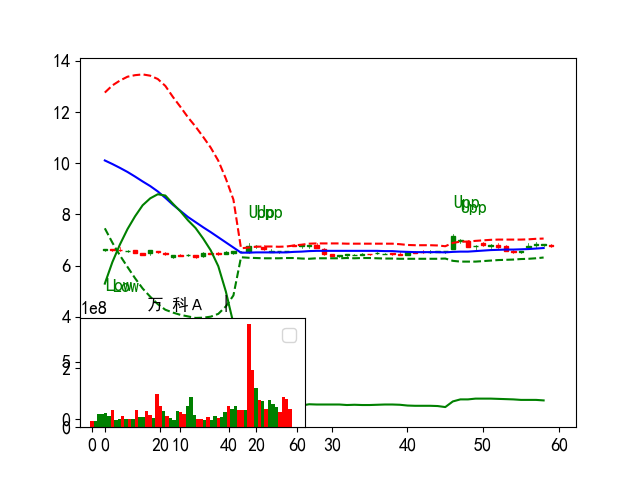

In [177]:
# dfs.loc['000002'][-60:]
show_ohlc_upper(dfsRoot.loc['000002'][-60:],code='000002')
for co in df_mask250.index.get_level_values(0)[:10]:
    print(co,dfs.loc[co].ra_diff[-1])
    show_ohlc_upper(dfsRoot.loc[co][-tail_days:],code=co)

## 最近60天数据

In [178]:
dfs_tail9 = dfs.groupby(level=[0]).tail(tail_days)

# 提取倒数第二天
# dfs_tail9 = dfs.groupby(level=[0]).tail(6)
# dfs_tail9 = dfs_tail9[dfs_tail9.index.get_level_values(1) <lastday]


# dfs_tail9.index.get_level_values(0)
# 还原多索引
# dfs_tail = dfs_tail.reset_index().set_index(['code','date'])
# print(dfs_tail9.loc['002987'][:1])
# show_tdx_data(dfs_tail9.loc[code_t])
# dfs_tail9=compute_perd_value(dfs_tail9,market_value=5,col='vol')

# show_tdx_data(dfs_tail9.loc[code_t])
# print((dfs_tail9.loc[code_t]))

In [179]:
dfs_tail9.loc[(['999999','399001','399006'],'ra_diff')].groupby(level=0).tail(3)
# dfs_tail9.loc[pd.IndexSlice[['999999','399001','399006'], :, :]].tail(3)
# dfs_tail9.query(("code == '999999'" and "date > '2023-04-01'"))

code    date      
999999  2025-09-08    1.13
        2025-09-09    1.13
        2025-09-10    1.13
399001  2025-09-08    1.25
        2025-09-09    1.24
        2025-09-10    1.24
399006  2025-09-08    1.44
        2025-09-09    1.41
        2025-09-10    1.43
Name: ra_diff, dtype: float64

## 超跌反弹年线大于MA20

In [180]:
# show_tdx_data(dfs_tail9.loc['300418'])[-2:]
show_tdx_data(dfs_tail9.loc['603131'])
# print(dfs_tail9.loc['603131',['high','upper','hmax']])

Count:30 32


name  ra_diff  xratio  idx   hat  close     volsum5d   hmax   lmin  \
date                                                                            
2025-08-01    0     1.05     0.0  0.0  1.17  17.91  443625224.2  19.31  17.19   
2025-08-04    0     1.09     0.0  0.0  1.27  18.45  443625169.2  19.31  17.19   
2025-08-05    0     1.10     0.0  0.0  1.42  18.73  443625199.3  19.31  17.19   
2025-08-06    0     1.11     0.0  0.0  1.61  18.94  443625209.2  19.50  17.19   
2025-08-07    0     1.16     0.0  0.0  2.15  19.66  443625479.6  20.83  17.19   
2025-08-08    0     1.27     0.0  0.0  3.80  21.62        260.7  21.62  17.19   
2025-08-11    0     1.32     0.0  0.0  5.27  22.38        231.6  22.56  17.19   
2025-08-12    0     1.23     0.0  0.0  5.68  20.91        185.5  22.56  17.19   
2025-08-13    0     1.21     0.0  0.0  5.88  20.58        166.4  22.56  17.19   
2025-08-14    0     1.16     0.0  0.0  5.87  19.70          0.6  22.56  17.19   
2025-08-15    0     1.18     0.0  0.0  5.87  20.02        -75.9  22.56  17.19   
2025-08-18    0     1.18     0.0  0.0  5.85  20.06        -96.2  22.56  17.19   
2025-08-19    0     1.22     0.0  0.0  5.78  20.70          4.6  22.56  17.28   
2025-08-20    0     1.23     0.0  0.0  5.71  20.91         14.1  22.56  17.31   
2025-08-21    0     1.19     0.0  0.0  5.43  20.23        -32.2  22.56  17.70   
2025-08-22    0     1.20     0.0  0.0  5.24  20.45        -28.0  22.56  17.70   
2025-08-25    0     1.26     0.0  0.0  5.23  21.34        172.7  22.56  17.70   
2025-08-26    0     1.27     0.0  0.0  5.18  21.62        124.6  22.56  17.70   
2025-08-27    0     1.22     0.0  0.0  4.91  20.75        104.9  22.56  17.70   
2025-08-28    0     1.26     0.0  0.0  4.66  21.42        153.7  22.56  17.70   

            perc1d   ma20  ma250         vol1d         vol2d         vol3d  \
date                                                                         
2025-08-01   29.13  13.98  13.26  4.436253e+08 -1.000000e+02 -1.473000e+01   
2025-08-04    3.02  14.20  13.27  4.281000e+01  4.436253e+08 -1.000000e+02   
2025-08-05    1.52  14.46  13.29  5.360000e+00  4.281000e+01  4.436253e+08   
2025-08-06    1.12  14.72  13.30 -4.850000e+00  5.360000e+00  4.281000e+01   
2025-08-07    3.80  15.02  13.32  1.704700e+02 -4.850000e+00  5.360000e+00   
2025-08-08    9.97  15.42  13.35  4.695000e+01  1.704700e+02 -4.850000e+00   
2025-08-11    3.52  15.85  13.38  1.365000e+01  4.695000e+01  1.704700e+02   
2025-08-12   -6.57  16.20  13.40 -4.072000e+01  1.365000e+01  4.695000e+01   
2025-08-13   -1.58  16.56  13.42 -2.391000e+01 -4.072000e+01  1.365000e+01   
2025-08-14   -4.28  16.86  13.44  4.680000e+00 -2.391000e+01 -4.072000e+01   
2025-08-15    1.62  17.18  13.46 -2.965000e+01  4.680000e+00 -2.391000e+01   
2025-08-18    0.20  17.49  13.48 -6.610000e+00 -2.965000e+01  4.680000e+00   
2025-08-19    3.19  17.83  13.50  6.012000e+01 -6.610000e+00 -2.965000e+01   
2025-08-20    1.01  18.19  13.53 -1.443000e+01  6.012000e+01 -6.610000e+00   
2025-08-21   -3.25  18.53  13.54 -4.164000e+01 -1.443000e+01  6.012000e+01   
2025-08-22    1.09  18.87  13.56 -2.539000e+01 -4.164000e+01 -1.443000e+01   
2025-08-25    4.35  19.24  13.58  1.940400e+02 -2.539000e+01 -4.164000e+01   
2025-08-26    1.31  19.61  13.60  1.197000e+01  1.940400e+02 -2.539000e+01   
2025-08-27   -4.02  19.94  13.62 -3.405000e+01  1.197000e+01  1.940400e+02   
2025-08-28    3.23  20.32  13.65  7.100000e+00 -3.405000e+01  1.197000e+01   

                   vol4d         vol5d  perc3d  perc5d  
date                                                    
2025-08-01 -2.477000e+01  9.780000e+01   26.66   31.30  
2025-08-04 -1.473000e+01 -2.477000e+01   30.02   31.79  
2025-08-05 -1.000000e+02 -1.473000e+01   35.04   32.46  
2025-08-06  4.436253e+08 -1.000000e+02    5.75   33.47  
2025-08-07  4.281000e+01  4.436253e+08    6.56   41.74  
2025-08-08  5.360000e+00  4.281000e+01   15.43   20.71  
2025-08-11 -4.850000e+00  5.360000e+00   18.16   21.30 

## !!! Run-Filter强势Upper

### !!! filterRule test

In [181]:
# dfs_tail9.loc['002722']


def rules_to_list(rules):
    rules_l = (rules).split('&')
    for l in rules_l:
        print(l)
    return rules_l


def filter_rule_Test(dfs_tail9,resample=resample):
    col_rule = ["(dfs_tail9[('close')] > dfs_tail9[('ma5')])",
                "(dfs_tail9[('high')] > dfs_tail9.upper)",
                "(dfs_tail9[('ma5')] > dfs_tail9[('ma20')])"]
    col_rule2 = [
        "(dfs_tail9[('close')] > dfs_tail9[('hmax')].shift(1)*0.98) | (dfs_tail9['close'] > dfs_tail9['hmax']*0.97)",
        "((dfs_tail9[('vol1d')] > 0) | (dfs_tail9.close > dfs_tail9.close.shift(1)*0.99))"]
    col_rule3 = [
        "((dfs_tail9[('vol2d')] > 0) | (dfs_tail9.close.shift(1) > dfs_tail9.close.shift(2)*0.99))"]

    col_rule_tail1 = ["(dfs_tail9.perc1d < 21)", "(dfs_tail9.perc2d > 0)"]
    if resample.upper()=='D':
        col_rule_tail2 = [
            "((dfs_tail9.perc3d > 0) | ((dfs_tail9.close.shift(2) > dfs_tail9.ma5.shift(2))) )",
            "((dfs_tail9.volsum5d > 50) )",
            "(dfs_tail9['close'] > dfs_tail9[('hmax')])",
            "(dfs_tail9[('close')] > dfs_tail9[('ma250')])",
            "(dfs_tail9['low'] > dfs_tail9[('low')].shift(1))"]
        col_rule_tail3 = ["(dfs_tail9[('hmax')] > 0)",
                 "(dfs_tail9[('high')] >= dfs_tail9[('hmax')])",
                 "(dfs_tail9[('close')] > dfs_tail9.ma250 * 0.99)"]
    else:
        col_rule_tail2 = [
            "((dfs_tail9.perc3d > 0) | ((dfs_tail9.close.shift(2) > dfs_tail9.ma5.shift(2))) )",
            "((dfs_tail9.volsum5d > 50) )",
            "(dfs_tail9['close'] > dfs_tail9[('hmax')])",
            "(dfs_tail9['low'] > dfs_tail9[('low')].shift(1))"]
        col_rule_tail3 = ["(dfs_tail9[('hmax')] > 0)",
                 "(dfs_tail9[('high')] >= dfs_tail9[('hmax')])"]
    col_rule_tail4=[ "(dfs_tail9[('xratio')] > dfs_tail9[('xratio')].shift(1))",
             "(dfs_tail9[('xratio')].shift(1) > dfs_tail9[('xratio')].shift(2))"]
    
    col_rule.extend(col_rule2)
    col_rule.extend(col_rule3)
    col_rule.extend(col_rule_tail1)
    col_rule.extend(col_rule_tail2)
    col_rule.extend(col_rule_tail3)
    col_rule.extend(col_rule_tail4)
    
    for co in col_rule:
        print("%s:%s" % (co, eval(co)), end='')



30
9 -0.04 -0.35


'Bear'

-0.35

date
2025-09-05    0.01
2025-09-08    0.01
2025-09-09    0.00
2025-09-10   -0.00
2025-09-11   -0.00
Name: xratio, dtype: float64

xratio:-0.01 ra_diff:nan
code: 601728


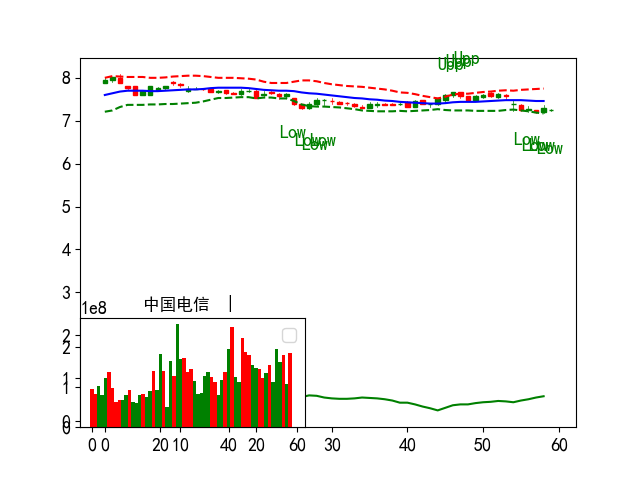

In [182]:
code_filter = '601728'

print(len(dfs_tail9.loc[code_filter]))

# show_tdx_data(dfs_tail9.loc[code_filter])
detect_bull_bear(dfs.loc[code_filter][-120:].close)
detect_bull_bear_apply(dfs.loc[code_filter][-120:].close)

dfs.loc[code_filter].xratio[-5:]

# filter_rule_Test(dfs_tail9.loc[code_filter])

show_ohlc_upper(dfsRoot.loc[code_filter][-60:], code=code_filter)



In [183]:
# dfs.loc['300474'][-5:]

### 新高Hmax日见新高df_mask_hmax

#### hmax 追高 TEST

30
xratio:-0.07 ra_diff:nan
code: 600012


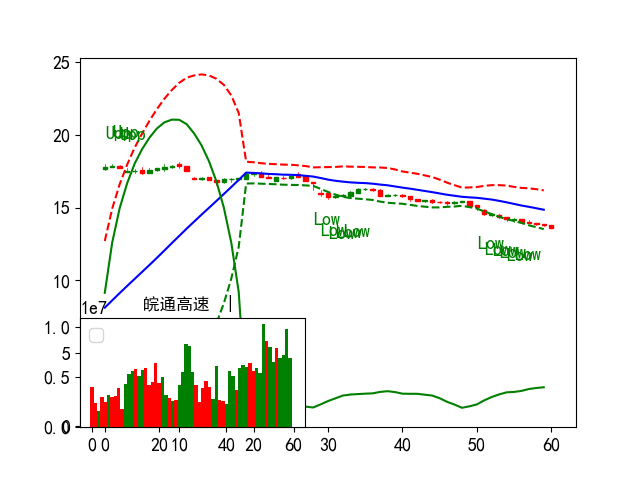

In [184]:
code='600012'
print(len(dfs_tail9.loc[code]))
# show_tdx_data(dfs_tail9.loc[code],col='upper')
show_ohlc_upper(dfsRoot.loc[code],code=code)

In [185]:

# mask_hmax = ((dfs_tail9[('close')] > dfs_tail9[('hmax')].shift(
#     1) * 0.99) | (dfs_tail9['close'] > dfs_tail9['hmax'] * 0.99))

# mask_hmax = ( (dfs_tail9[('hmax')] > 0) & ((dfs_tail9[('high')] > dfs_tail9[('hmax')].shift(
#     1) * 0.99) | (dfs_tail9['high'] > dfs_tail9['hmax'] * 0.99)) )

# mask_hmax = ((dfs_tail9[('hmax')] > 0) &

if resample.upper() =='D':
    mask_hmax = ( (dfs_tail9[('high')] > dfs_tail9[('hmax')].shift(1)) &
                 ((dfs_tail9[('high')] >= dfs_tail9[('hmax')])) &
                 (dfs_tail9[('close')] > dfs_tail9.ma250 * 0.99))
                 # (dfs_tail9[('close')] > dfs_tail9.ma250 * 0.99) &
                 # (dfs_tail9[('close')] < dfs_tail9.ma250 * 1.05))
else:
    mask_hmax = ( (dfs_tail9[('low')] >= dfs_tail9[('ma5')].shift(1))  &
              (dfs_tail9[('high')] >= dfs_tail9[('high')].shift(1))  ) 

# mask_hmax = ( (dfs_tail9[('hmax')] > 0) & (dfs_tail9[('close')] > dfs_tail9.ma20 *0.99) & (dfs_tail9[('close')] < dfs_tail9.ma20 *1.20) )


df_mask_hmax = dfs_tail9.loc[idx[mask_hmax, :]]
df_mask_hmax = get_multi_code_count(df_mask_hmax)

# df_mask_hmax = df_mask_hmax[ (df_mask_hmax[('close')] > df_mask_hmax.upper)]

# df_mask_hmax.couts.std()

df_mask_hmax = df_mask_hmax.groupby(level=[0]).tail(
    1).reset_index().set_index('code')

df_mask_hmax = df_mask_hmax[df_mask_hmax.date >= lastday]
# df_mask_hmax = get_sina_data_cname(df_mask_hmax, dm,realtime=True)
df_mask_hmax = get_sina_data_cname(df_mask_hmax, realtime=True)

df_mask_hmax = clean_688(df_mask_hmax)

# show_tdx_data(df_mask_hmax[df_mask_hmax.couts == 9])

# by=['perc', 'perc5d', 'perc1d'],
# code_t = '000534'
df_mask_hmax = df_mask_hmax.sort_values(
    by=['couts','volsum5d', 'idx', 'hat', 'perc1d'],ascending=[0,0, 0, 0, 0])
    # by=['volsum5d', 'idx', 'hat', 'perc1d'],ascending=[0, 0, 0, 0])
# print(df_mask_hmax.couts[:1], df_mask_hmax.shape)
# show_tdx_data(df_mask_hmax.loc['300461'])
df_mask_hmax.couts[:1], df_mask_hmax.shape
show_tdx_data(df_mask_hmax)
# show_tdx_data(df_mask_hmax[(df_mask_hmax.couts > 1) & (df_mask_hmax.volsum5d > 10) & (df_mask_hmax.volsum5d < 150)]).T

count dd.couts
compute percent


(code
 301448    16
 Name: couts, dtype: int64,
 (457, 41))

Count:457 41


name  couts       date   perc  ra_diff  xratio    idx  hat   close  \
code                                                                          
301448   开创电气     16 2025-09-11   0.29      0.0    1.34  23.03  0.0   65.44   
300476   胜宏科技     13 2025-09-11   5.50      0.0    3.40  39.50  0.0  306.75   
601717   中创智领     13 2025-09-11  -0.13      0.0    0.25   2.32  0.0   22.77   
603516   淳中科技     13 2025-09-11  10.03      0.0    0.27  35.74  0.0  137.12   
002058  *ST威尔     12 2025-09-11   4.94      0.0    0.36   5.96  0.0   22.73   
603163   圣晖集成     12 2025-09-11  -1.59      0.0    0.72  11.09  0.0   50.00   
300409   道氏技术     12 2025-09-11   4.98      0.0    0.27   5.29  0.0   26.77   
603444    吉比特     12 2025-09-11   4.44      0.0    4.22  40.25  0.0  499.50   
002106   莱宝高科     11 2025-09-11   2.70      0.0    0.05   1.02  0.0   12.53   
300857   协创数据     11 2025-09-11   1.56      0.0    1.55  29.81  0.0  130.00   
601138   工业富联     11 2025-09-11  10.01      0.0    0.68   5.19  0.0   59.03   
603090   宏盛股份     11 2025-09-11   0.90      0.0    0.52  11.10  0.0   45.88   
600660   福耀玻璃     11 2025-09-11   3.23      0.0    0.75   6.25  0.0   71.94   
603813  *ST原尚     10 2025-09-11   1.47      0.0    0.26   2.53  0.0   21.34   
002812   恩捷股份     10 2025-09-11   2.59      0.0    0.42  12.38  0.0   44.69   
301377   鼎泰高科     10 2025-09-11  11.94      0.0    0.77   4.31  0.0   79.69   
002101   广东鸿图      9 2025-09-11  -3.12      0.0    0.01   1.00  0.0   13.98   
002364   中恒电气      9 2025-09-11   8.79      0.0    0.37   2.67  0.0   29.47   
301538    骏鼎达      9 2025-09-11   8.13      0.0    0.89  30.50  0.0   99.00   
002311   海大集团      9 2025-09-11   0.78      0.0    0.25   3.25  0.0   64.75   

        volsum5d  ...  ma250  nclose    llow  vol1d    vol2d   vol3d   vol4d  \
code              ...                                                          
301448      17.1  ...    0.0   65.62   62.25 -100.0    23.67   15.52   61.44   
300476     -71.2  ...    0.0  301.25  290.50 -100.0    41.93  -22.60   -7.53   
601717     -92.0  ...    0.0   23.00   22.61 -100.0   -34.86   59.13    9.06   
603516     -93.5  ...    0.0  134.25  125.00 -100.0    28.39  -36.66   36.31   
002058     825.4  ...    0.0   22.73   22.73 -100.0  1014.06   31.57  -94.64   
603163     -51.3  ...    0.0   49.75   48.69 -100.0    34.37   13.13   12.58   
300409     -90.5  ...    0.0   26.14   24.56 -100.0    37.86  -43.28    2.58   
603444    -129.8  ...    0.0  485.75  466.75 -100.0    -4.42  -25.71   21.52   
002106      33.9  ...    0.0   12.53   12.07 -100.0    19.97  -38.69   22.11   
300857     -38.7  ...    0.0  128.50  125.00 -100.0    53.97  -24.10   49.15   
601138     -90.5  ...    0.0   57.66   54.66 -100.0    32.00  -13.54  -10.57   
603090     -95.9  ...    0.0   45.16   43.88 -100.0    20.31   30.61  -24.81   
600660    -135.6  ...    0.0   71.44   69.69 -100.0   -16.92   11.46    4.00   
603813     117.7  ...    0.0   21.41   21.08 -100.0   -48.78  209.82  -24.91   
002812     -65.3  ...    0.0   44.59   43.00 -100.0    -7.64  -24.74   65.26   
301377     -94.0  ...    0.0   80.31   71.62 -100.0    62.75   -1.17  -47.56   
002101      81.4  ...    0.0   14.04   13.95 -100.0   151.98   30.61    5.78   
002364      18.3  ...    0.0   27.86   26.66 -100.0   -24.00  -41.29  215.35   
301538     -36.5  ...    0.0   97.94   89.25 -100.0    -5.06    7.63   62.15   
002311     -36.8  ...    0.0   65.19   64.38 -100.0   -66.02  105.63   65.44   

         vol5d  perc3d  perc5d  
code                            
301448   16.50   18.72   48.63  
300476   17.05   12.16   24.44  
601717  -25.36    4.26    9.05  
603516  -21.55   33.13   39.12  
002058  -25.63   15.62   27.62  
603163  -11.34   19.05   24.13  
300409   12.31   10.12   21.35  
603444  -21.17    4.72   11.93  
002106  130.48    3.90   14.53  
300857  -17.71   15.43   35.42  
601138    1.58   14.82   11.13  
603090  -22.03    7.65   10.05  
600660  -34.12    3.88    6.88  
603813   81.55

#### !!! hmax Top upper > 1

In [186]:
# dfs_tail9.loc['600103']

In [187]:
# mask_hmax = ((dfs_tail9[('close')] > dfs_tail9[('hmax')].shift(
#     1) * 0.99) | (dfs_tail9['close'] > dfs_tail9['hmax'] * 0.99))

# mask_hmax = ( (dfs_tail9[('hmax')] > 0) & ((dfs_tail9[('high')] > dfs_tail9[('hmax')].shift(
#     1) * 0.99) | (dfs_tail9['high'] > dfs_tail9['hmax'] * 0.99)) )

# mask_hmax = ( (dfs_tail9[('hmax')] > 0) & ((dfs_tail9[('high')] >= dfs_tail9[('hmax')]*0.99) ) )
# mask_hmax = (  (dfs_tail9[('high')] >= dfs_tail9[('hmax')]*0.99) )
if resample.upper() == 'D':
    mask_hmax = (  (dfs_tail9[('high')] >= dfs_tail9[('high')].shift(1)) & 
                 (dfs_tail9[('high')].shift(1) >= dfs_tail9[('high')].shift(2)) &
                (dfs_tail9[('high')] >= dfs_tail9[('hmax')]*0.99) &
                (dfs_tail9[('close')] >= dfs_tail9[('upper')].shift(1)) )
else:
    mask_hmax = (  (dfs_tail9[('high')] >= dfs_tail9[('high')].shift(1)) & 
                 (dfs_tail9[('high')].shift(1) >= dfs_tail9[('high')].shift(2)) &
                (dfs_tail9[('close')] >= dfs_tail9[('upper')].shift(1)) )

df_mask_hmax = dfs_tail9.loc[idx[mask_hmax, :]]

#站上Upper
# df_mask_hmax = df_mask_hmax[ (df_mask_hmax[('close')] > df_mask_hmax.upper)]

df_mask_hmax = get_multi_code_count(df_mask_hmax)
df_mask_hmax = df_mask_hmax.groupby(level=[0]).tail(
    1).reset_index().set_index('code')



df_mask_hmax = df_mask_hmax[df_mask_hmax.date >= lastday]
# df_mask_hmax = get_sina_data_cname(df_mask_hmax, dm,realtime=True)
df_mask_hmax = get_sina_data_cname(df_mask_hmax, realtime=True)

df_mask_hmax = clean_688(df_mask_hmax)

# show_tdx_data(df_mask_hmax[df_mask_hmax.couts == 9])

# by=['perc', 'perc5d', 'perc1d'],
# code_t = '000534'
df_mask_hmax = df_mask_hmax.sort_values(
    by=['couts', 'idx', 'hat', 'perc1d'],
    ascending=[0, 0, 0, 0])
 # by=['volsum5d', 'idx', 'hat', 'perc1d'],
print(df_mask_hmax.couts[:1], df_mask_hmax.shape)
# show_tdx_data(df_mask_hmax.loc['000039'])
df_mask_hmax.couts[:1], df_mask_hmax.shape

# show_tdx_data(df_mask_hmax).T
# show_tdx_data(df_mask_hmax[(df_mask_hmax.couts > 1) & (df_mask_hmax.volsum5d > 10) & (df_mask_hmax.volsum5d < 150)])
show_tdx_data(df_mask_hmax.query('couts >= 1 and perc >2  and   low < ma5 '),limit=10 )

count dd.couts
compute percent
code
605580    13
Name: couts, dtype: int64 (155, 41)


(code
 605580    13
 Name: couts, dtype: int64,
 (155, 41))

Count:24 41


name  couts       date   perc  ra_diff  xratio   idx  hat  close  \
code                                                                       
002364  中恒电气      9 2025-09-11   8.79      0.0    0.37  2.67  0.0  29.47   
603222  济民健康      8 2025-09-11  10.02      0.0    0.22  2.54  0.0  14.06   
600601  方正科技      8 2025-09-11   9.96      0.0    0.16  1.59  0.0  10.27   
001332  锡装股份      7 2025-09-11   6.07      0.0    0.16  9.91  0.0  47.53   
002796  世嘉科技      7 2025-09-11   9.16      0.0    0.09  3.09  0.0  17.52   
001300   三柏硕      7 2025-09-11   3.80      0.0    0.06  1.14  0.0  15.03   
002106  莱宝高科      6 2025-09-11   2.70      0.0    0.05  1.02  0.0  12.53   
601099   太平洋      6 2025-09-11   3.13      0.0    0.03  0.54  0.0   4.95   
300409  道氏技术      5 2025-09-11   4.98      0.0    0.27  5.29  0.0  26.77   
300852  四会富仕      5 2025-09-11  19.97      0.0    0.19  4.72  0.0  44.28   

        volsum5d  ...  ma250  nclose   llow  vol1d  vol2d   vol3d   vol4d  \
code              ...                                                       
002364      18.3  ...    0.0   27.86  26.66 -100.0 -24.00  -41.29  215.35   
603222     111.4  ...    0.0   13.82  11.88 -100.0  -1.22   74.45  -22.15   
600601     -84.0  ...    0.0   10.20   9.37 -100.0  42.89  -25.28  -11.97   
001332     262.6  ...    0.0   46.38  43.22 -100.0 -27.76  183.53   98.75   
002796    -100.8  ...    0.0   16.69  14.97 -100.0  56.45   -9.90  -21.56   
001300     124.2  ...    0.0   14.55  14.22 -100.0  86.84  -44.18   -9.95   
002106      33.9  ...    0.0   12.53  12.07 -100.0  19.97  -38.69   22.11   
601099    -152.8  ...    0.0    4.94   4.72 -100.0  24.61  -23.10  -30.74   
300409     -90.5  ...    0.0   26.14  24.56 -100.0  37.86  -43.28    2.58   
300852     -84.8  ...    0.0   43.47  37.19 -100.0  86.97  -19.44  -16.92   

         vol5d  perc3d  perc5d  
code                            
002364  -31.76   10.25   28.63  
603222  160.35   21.63   22.05  
600601   10.39   10.67   17.24  
001332  108.11   13.49   29.23  
002796  -25.81   11.81   15.26  
001300  191.54    5.47   10.76  
002106  130.48    3.90   14.53  
601099  -23.52    3.99    3.34  
300409   12.31   10.12   21.35  
300852  -35.39   21.32   26.73  

[10 rows x 24 columns]

In [188]:
# show_tdx_data(df_mask_hmax.loc['600103'][-5:])

##### sort_values

In [189]:
show_tdx_data(
    df_mask_hmax.query('perc > 1').sort_values(
        by=['ra_diff', 'couts', 'idx'],
        ascending=[0, 0, 0]),col='ra_diff')

Count:99 41


name  couts       date   perc  ra_diff  ra_diff  xratio    idx  hat  \
code                                                                           
605580   恒盛能源     13 2025-09-11   1.87      0.0      0.0    0.38   5.64  0.0   
603516   淳中科技     11 2025-09-11  10.03      0.0      0.0    0.27  35.74  0.0   
600243  *ST海华     11 2025-09-11   2.31      0.0      0.0    0.06   0.69  0.0   
002058  *ST威尔     10 2025-09-11   4.94      0.0      0.0    0.36   5.96  0.0   
605287   德才股份     10 2025-09-11  10.04      0.0      0.0    0.12   5.22  0.0   
002602   ST华通     10 2025-09-11   2.17      0.0      0.0    0.23   3.74  0.0   
002364   中恒电气      9 2025-09-11   8.79      0.0      0.0    0.37   2.67  0.0   
600103   青山纸业      9 2025-09-11  10.14      0.0      0.0    0.04   1.45  0.0   
000980   众泰汽车      9 2025-09-11   3.05      0.0      0.0    0.04   0.81  0.0   
300857   协创数据      8 2025-09-11   1.56      0.0      0.0    1.55  29.81  0.0   
002115   三维通信      8 2025-09-11   2.53      0.0      0.0    0.23   3.69  0.0   
603222   济民健康      8 2025-09-11  10.02      0.0      0.0    0.22   2.54  0.0   
600601   方正科技      8 2025-09-11   9.96      0.0      0.0    0.16   1.59  0.0   
300692   中环环保      8 2025-09-11   3.89      0.0      0.0    0.06   1.42  0.0   
002630   ST华西      8 2025-09-11   1.16      0.0      0.0    0.04   0.70  0.0   
001332   锡装股份      7 2025-09-11   6.07      0.0      0.0    0.16   9.91  0.0   
002796   世嘉科技      7 2025-09-11   9.16      0.0      0.0    0.09   3.09  0.0   
603359   东珠生态      7 2025-09-11   9.98      0.0      0.0    0.11   2.49  0.0   
001300    三柏硕      7 2025-09-11   3.80      0.0      0.0    0.06   1.14  0.0   
300476   胜宏科技      6 2025-09-11   5.50      0.0      0.0    3.40  39.50  0.0   

         close  ...  ma250  nclose    llow  vol1d    vol2d   vol3d   vol4d  \
code            ...                                                          
605580   26.72  ...    0.0   26.45   25.61 -100.0     4.39   10.64   22.72   
603516  137.12  ...    0.0  134.25  125.00 -100.0    28.39  -36.66   36.31   
600243    5.32  ...    0.0    5.27    5.00 -100.0   -19.76   12.44    7.93   
002058   22.73  ...    0.0   22.73   22.73 -100.0  1014.06   31.57  -94.64   
605287   21.27  ...    0.0   21.16   19.34 -100.0    24.55  -36.22  166.62   
002602   19.27  ...    0.0   18.83   18.20 -100.0     6.21    0.67   -5.30   
002364   29.47  ...    0.0   27.86   26.66 -100.0   -24.00  -41.29  215.35   
600103    3.80  ...    0.0    3.80    3.65 -100.0     5.81  -18.88  318.38   
000980    3.38  ...    0.0    3.34    3.26 -100.0   140.71  -28.24   42.63   
300857  130.00  ...    0.0  128.50  125.00 -100.0    53.97  -24.10   49.15   
002115   14.16  ...    0.0   14.20   13.40 -100.0    -7.69   35.85   -3.26   
603222   14.06  ...    0.0   13.82   11.88 -100.0    -1.22   74.45  -22.15   
600601   10.27  ...    0.0   10.20    9.37 -100.0    42.89  -25.28  -11.97   
300692    8.27  ...    0.0    8.23    7.90 -100.0    12.68  -25.83    3.28   
002630    3.48  ...    0.0    3.55    3.45 -100.0   -34.35   21.37   -6.88   
001332   47.53  ...    0.0   46.38   43.22 -100.0   -27.76  183.53   98.75   
002796   17.52  ...    0.0   16.69   14.97 -100.0    56.45   -9.90  -21.56   
603359   10.14  ...    0.0   10.14   10.14 -100.0   -97.92  102.00  -30.29   
001300   15.03  ...    0.0   14.55   14.22 -100.0    86.84  -44.18   -9.95   
300476  306.75  ...    0.0  301.25  290.50 -100.0    41.93  -22.60   -7.53   

         vol5d  perc3d  perc5d  
code                            
605580  -24.46   11.19   22.34  
603516  -21.55   33.13   39.12  
600243  -29.31   10.14   12.47  
002058  -25.63   15.62   27.62  
605287   24.20   18.17   32.28  
002602  -14.93   10.87   22.35  
002364  -31.76   10.25   28.63  
600103  -64.03   33.33   52.61  
000980  -27.95   14.97   32.55  
300857  -17.71   15.43   35.42  
002115  -22.97   16.45   18.00  
603222  160.35   21.63   22.05  
600601   10.39   10.67   17.24  
300692   -4.81    5.22   14.38  
002

xratio:-0.01 ra_diff:nan
code: 300540


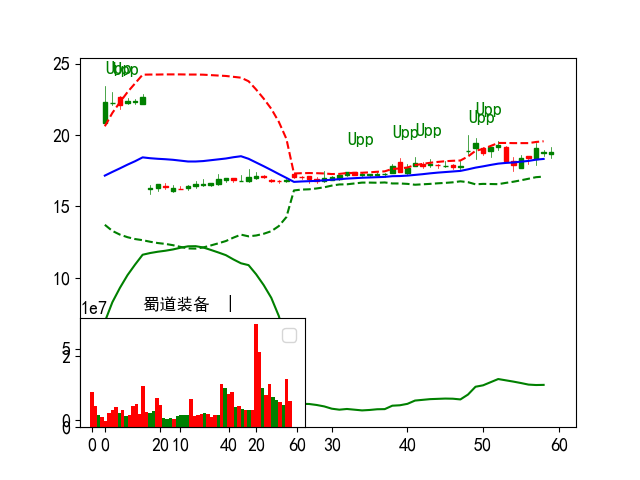

In [190]:
show_ohlc_upper(dfsRoot.loc['300540'][-60:],code='300540')

### !!! df_mask250 upper xratio 加速

In [191]:

if resample.upper() =='D':
    mask250 = ((dfs_tail9[('high')] > dfs_tail9.upper) &
               (dfs_tail9[('close')] > dfs_tail9[('ma5')])
               & (dfs_tail9[('ma5')] > dfs_tail9[('ma20')])
               & ((dfs_tail9[('vol1d')] > 0) | (dfs_tail9.close > dfs_tail9.close.shift( 1)*0.99))
               & ((dfs_tail9[('vol2d')] > 0) | (dfs_tail9.close.shift(1) > dfs_tail9.close.shift(2)*0.99))
               & (dfs_tail9['close'] > dfs_tail9[('hmax')]) &
                (dfs_tail9[('close')] > dfs_tail9[('ma250')]) | ((dfs_tail9[('high')] > dfs_tail9.upper) &
                                                                 (dfs_tail9[('close')] > dfs_tail9[('ma5')])) &
               (dfs_tail9[('ma5')] > dfs_tail9[('ma20')])
               & ((dfs_tail9[('vol1d')] > 0) | (dfs_tail9.close > dfs_tail9.close.shift(1)*0.99))
               & ((dfs_tail9[('vol2d')] > 0) | (dfs_tail9.close.shift(1) > dfs_tail9.close.shift(2)*0.99))
               & (dfs_tail9['low'] > dfs_tail9[('low')].shift(1))
               & (dfs_tail9[('close')] > dfs_tail9[('ma250')])
               & (dfs_tail9[('xratio')] > dfs_tail9[('xratio')].shift(1))
               & (dfs_tail9[('xratio')].shift(1) > dfs_tail9[('xratio')].shift(2))
              )
elif resample.upper() =='W' or resample == 'W-FRI':
    mask250 = (
               (dfs_tail9[('close')] > dfs_tail9[('ma5')])
               & (dfs_tail9[('ma5')] > dfs_tail9[('ma20')])
               & ((dfs_tail9[('vol1d')] > 0) | (dfs_tail9.close > dfs_tail9.close.shift(1)*0.99))
               & ((dfs_tail9[('vol2d')] > 0) | (dfs_tail9.close.shift(1) > dfs_tail9.close.shift(2)*0.99))
               & (dfs_tail9['low'] > dfs_tail9[('low')].shift(1))
               & (dfs_tail9[('xratio')] > dfs_tail9[('xratio')].shift(1))
               & (dfs_tail9[('xratio')].shift(1) > dfs_tail9[('xratio')].shift(2))
              )
else:
    mask250 = (
               (dfs_tail9[('close')] > dfs_tail9[('ma5')])
               & (dfs_tail9[('ma5')] > dfs_tail9[('ma20')])
               & ((dfs_tail9[('vol1d')] > 0) | (dfs_tail9.close > dfs_tail9.close.shift(1)*0.99))
               & ((dfs_tail9[('vol2d')] > 0) | (dfs_tail9.close.shift(1) > dfs_tail9.close.shift(2)*0.99))
               & (dfs_tail9['low'] > dfs_tail9[('low')].shift(1))
              )

# & (dfs_tail9[('close')] < dfs_tail9[('ma20'  )]*1.1))
idx = pd.IndexSlice
df_mask250 = dfs_tail9.loc[idx[mask250, :]]
df_mask250.shape
#站上Upper
df_mask250 = df_mask250[ (df_mask250[('close')] > df_mask250.upper)]

df_mask250 = get_multi_code_count(df_mask250)


code_t = '603131'
print((df_mask250.couts[:3], df_mask250.shape))
# df_mask250.loc[code_t]
groupd250 = df_mask250.groupby(level=[0])
df_mask250 = groupd250.tail(1).reset_index().set_index('code')
# df_mask250 = get_sina_data_cname(df_mask250, dm,realtime=True)



# df_mask250.loc[code_t].close
df_mask250 = get_sina_data_cname(df_mask250, realtime=True)
# df_mask250.loc[code_t].close

df_mask250 = clean_688(df_mask250)
# df_masklastd.loc['002722']

df_mask250 = df_mask250.sort_values(
    by=['idx','xratio',  'hat', 'perc1d'],
    ascending=[0, 0, 0, 0])
    # by=['xratio', 'idx', 'hat', 'perc1d'],

# by=['perc', 'perc5d', 'perc1d'],
# ascending=[0, 0, 0])
print("df_mask250:%s df_mask_hmax:%s"%(len(df_mask250),len(df_mask_hmax)))
cross_hmax_250 = [co for co in df_mask250.index.get_level_values(
    'code') if co in df_mask_hmax.index.get_level_values('code')]
# df_mask250.loc[code_t]
print("cross_hamx:%s" % (len(cross_hmax_250)))
show_tdx_data(df_mask250.loc[cross_hmax_250].query('couts > 1 and perc > 0'))
# show_tdx_data(df_mask250.query('couts > 1 and perc > 0')[:20])
# show_tdx_data(df_mask250.loc[code_t])

(1083, 32)

count dd.couts
(code    date      
605255  2025-08-29    6
        2025-09-01    6
        2025-09-02    6
Name: couts, dtype: int64, (954, 33))
compute percent
df_mask250:676 df_mask_hmax:155
cross_hamx:126
Count:13 41


name  couts       date   perc  ra_diff  xratio    idx  hat   close  \
code                                                                          
300857   协创数据      2 2025-09-11   1.56      0.0    1.55  29.81  0.0  130.00   
301448   开创电气      4 2025-09-11   0.29      0.0    1.34  23.03  0.0   65.44   
002384   东山精密      2 2025-09-11   8.57      0.0    0.78  12.44  0.0   78.44   
002812   恩捷股份      6 2025-09-11   2.59      0.0    0.42  12.38  0.0   44.69   
603090   宏盛股份      3 2025-09-11   0.90      0.0    0.52  11.10  0.0   45.88   
603301   振德医疗      3 2025-09-11  10.05      0.0    0.24   8.11  0.0   32.41   
002058  *ST威尔      3 2025-09-11   4.94      0.0    0.36   5.96  0.0   22.73   
601116   三江购物      2 2025-09-11   9.96      0.0    0.16   5.36  0.0   16.23   
000893   亚钾国际      4 2025-09-11   1.41      0.0    0.26   4.34  0.0   38.22   
001358   兴欣新材      2 2025-09-11   4.36      0.0    0.12   3.76  0.0   29.45   
002602   ST华通      4 2025-09-11   2.17      0.0    0.23   3.74  0.0   19.27   
301178    天亿马      2 2025-09-11   1.19      0.0    0.23   3.53  0.0   58.69   
002545   东方铁塔      3 2025-09-11   4.26      0.0    0.09   2.56  0.0   12.72   

        volsum5d  ...  ma250  nclose    llow  vol1d    vol2d  vol3d   vol4d  \
code              ...                                                         
300857     -38.7  ...    0.0  128.50  125.00 -100.0    53.97 -24.10   49.15   
301448      17.1  ...    0.0   65.62   62.25 -100.0    23.67  15.52   61.44   
002384     -90.6  ...    0.0   77.50   75.00 -100.0    -4.32 -22.98   25.01   
002812     -65.3  ...    0.0   44.59   43.00 -100.0    -7.64 -24.74   65.26   
603090     -95.9  ...    0.0   45.16   43.88 -100.0    20.31  30.61  -24.81   
603301      67.9  ...    0.0   32.22   29.45 -100.0    77.23  -4.63  125.44   
002058     825.4  ...    0.0   22.73   22.73 -100.0  1014.06  31.57  -94.64   
601116    -118.2  ...    0.0   16.20   15.01 -100.0    16.28  12.64  -27.31   
000893      31.6  ...    0.0   38.16   37.66 -100.0   -31.21  44.01  151.50   
001358      33.0  ...    0.0   28.53   27.66 -100.0   103.85 -22.84   62.66   
002602    -113.3  ...    0.0   18.83   18.20 -100.0     6.21   0.67   -5.30   
301178       2.0  ...    0.0   58.09   56.34 -100.0    68.89  37.66  -21.82   
002545      96.3  ...    0.0   12.70   12.23 -100.0    49.83  89.85   28.62   

        vol5d  perc3d  perc5d  
code                           
300857 -17.71   15.43   35.42  
301448  16.50   18.72   48.63  
002384  11.73   19.54   34.80  
002812   1.85   12.88   32.93  
603090 -22.03    7.65   10.05  
603301 -30.16   19.95   30.53  
002058 -25.63   15.62   27.62  
601116 -19.86   33.03   27.49  
000893 -32.66    8.70   17.49  
001358 -10.66   11.05   18.04  
002602 -14.93   10.87   22.35  
301178  17.24    7.75   12.39  
002545  28.03   13.77   25.57  

[13 rows x 24 columns]

df_mask250:50
603200 0.0
xratio:1.01 ra_diff:nan
code: 603200


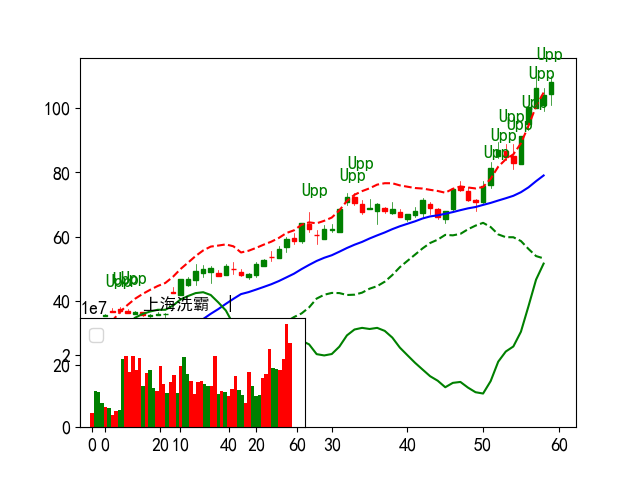

301538 0.0
xratio:0.57 ra_diff:nan
code: 301538


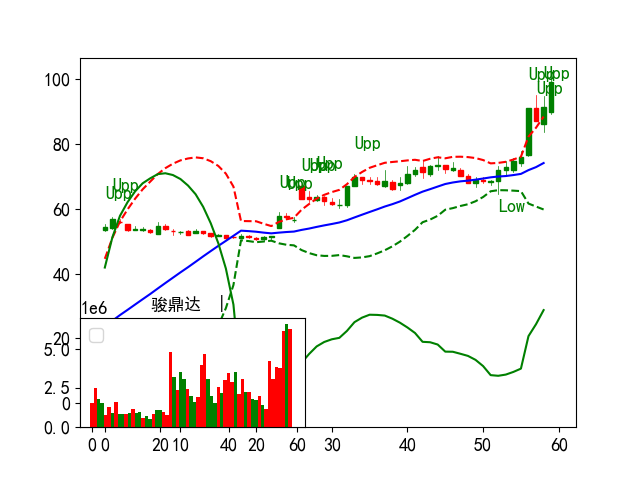

300857 0.0
xratio:0.51 ra_diff:nan
code: 300857


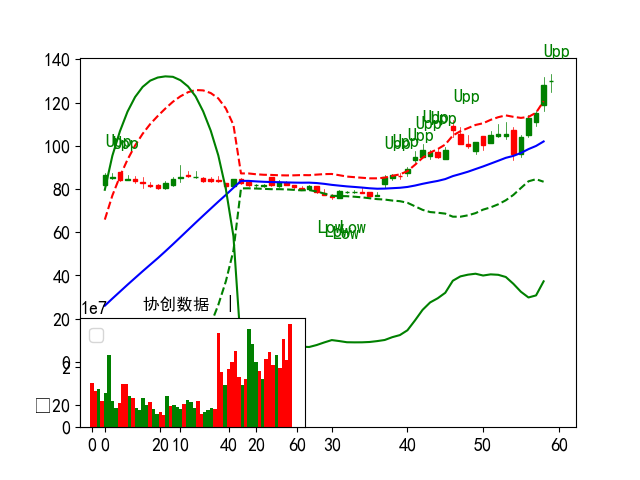

300014 0.0
xratio:0.37 ra_diff:nan
code: 300014


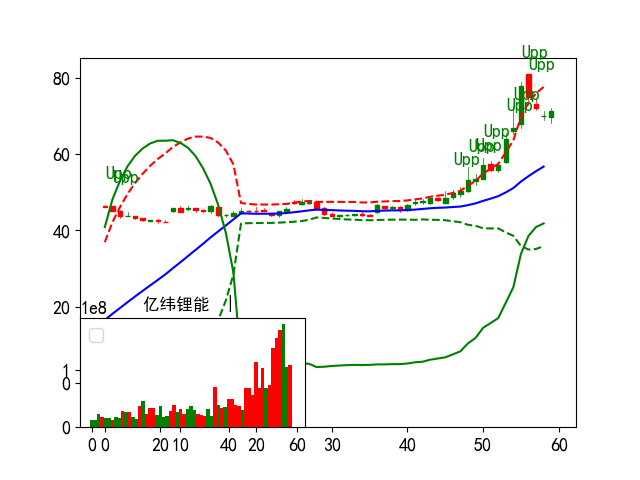

300450 0.0
xratio:0.44 ra_diff:nan
code: 300450


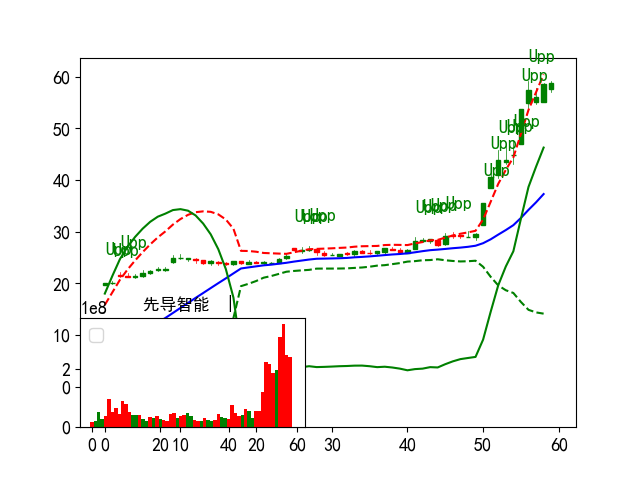

301448 0.0
xratio:0.48 ra_diff:nan
code: 301448


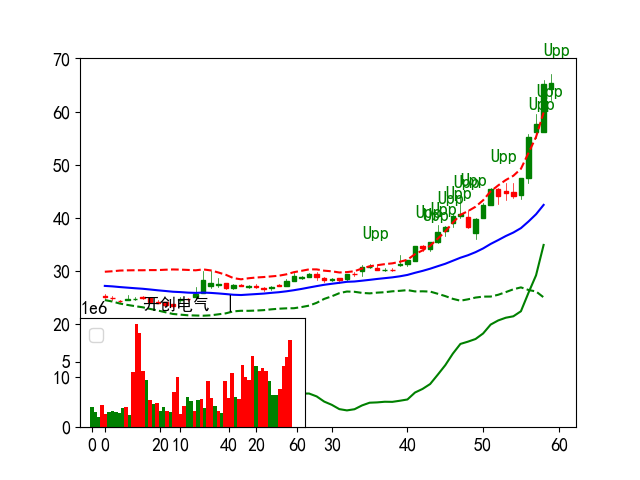

603822 0.0
xratio:0.4 ra_diff:nan
code: 603822


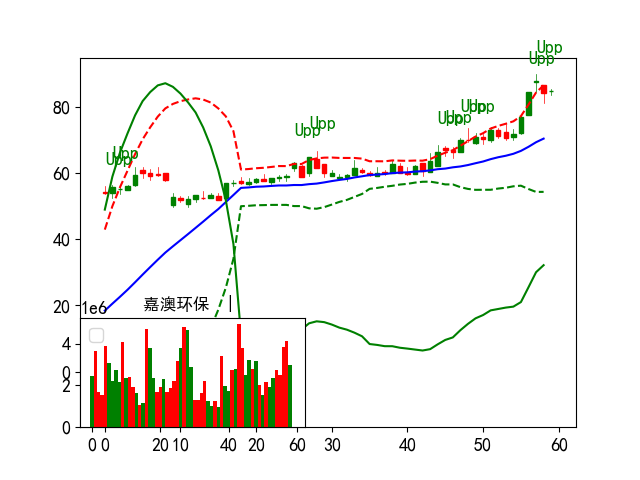

605117 0.0
xratio:0.04 ra_diff:nan
code: 605117


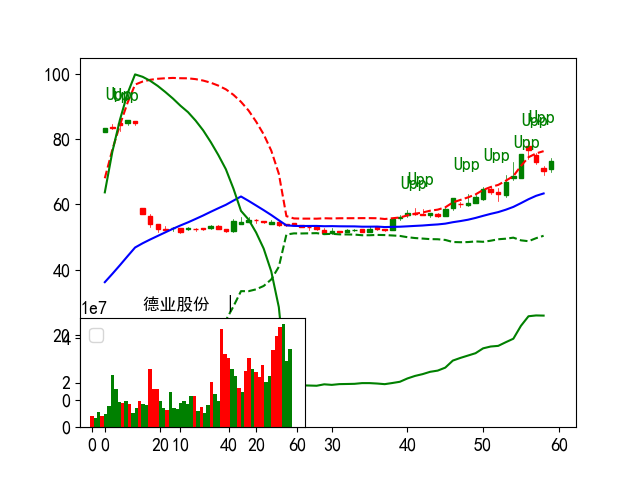

603179 0.0
xratio:0.22 ra_diff:nan
code: 603179


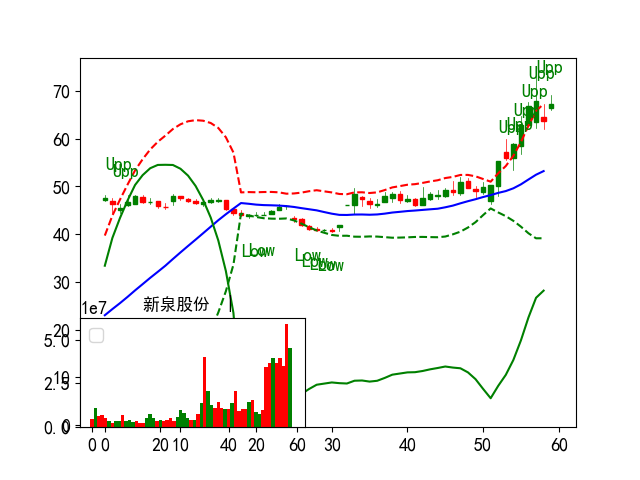

002384 0.0
xratio:0.6 ra_diff:nan
code: 002384


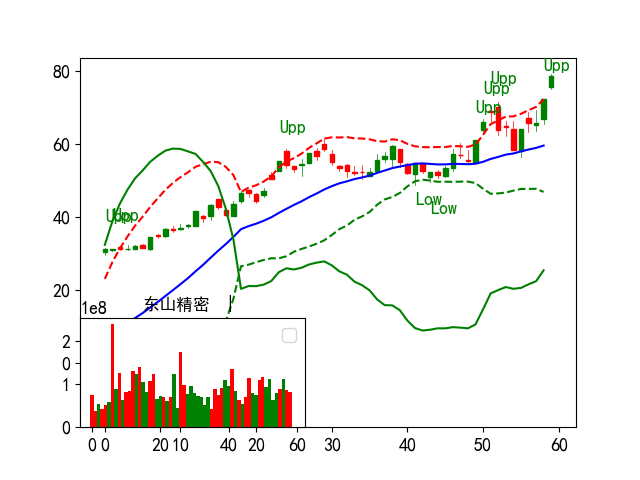

In [192]:
print("df_mask250:%s"%(len(df_mask250.query('couts > 1 and perc > 0'))))
for co in df_mask250.query('couts > 1 and perc > 0').index[:10]:
    print(co,dfs.loc[co].ra_diff[-1])
    show_ohlc_upper(dfsRoot.loc[co][-60:],code=co)

### Tail1 Show Top 主升浪df_masklastd

In [193]:
df_mask250[(df_mask250.date >= lastday_week)][:2]
df_mask250[df_mask250.ra_diff > 1.3].shape

date   lopen   lhigh    llow  close        vol       amount  \
code                                                                       
300308 2025-09-11  402.25  421.75  402.25  418.5      33.52       139.05   
605255 2025-09-10   76.00   76.00   76.00   76.0  567754.00  43149304.00   

        ra_diff    ma10     ma5  ...  xratio    idx  couts  nclose    open  \
code                             ...                                         
300308     0.00  388.02  387.95  ...    8.89  63.50      1  414.75  402.25   
605255     4.45   51.36   63.37  ...    1.91  43.78      6     NaN     NaN   

          high     low  llastp            ticktime  perc  
code                                                      
300308  421.75  402.25   385.0 2025-09-11 10:40:48   8.7  
605255     NaN     NaN     NaN                 NaT   NaN  

[2 rows x 41 columns]

(97, 41)

In [194]:
# df_masklastd = df_mask250[(df_mask250.date >= '2023-02-06') & (df_mask250.perc1d < 21) & (df_mask250.perc2d > 0) &
if resample.upper() =='D':
    df_masklastd = df_mask250[(df_mask250.date >= lastday) & (df_mask250.perc1d < 21) & (df_mask250.perc2d > 0)
                          & ((df_mask250.volsum5d > 10) & (df_mask250.close > df_mask250.ma5) )
                          ]
                          # & ((df_mask250.perc3d > 0) | ((df_mask250.close.shift(2) > df_mask250.ma5.shift(2))) )
else:
    df_masklastd = df_mask250[(df_mask250.date >= lastday_week) & (df_mask250.perc1d < 21) & (df_mask250.perc2d > 0)
                          & ((df_mask250.volsum5d > 20) & (df_mask250.close > df_mask250.ma5) )
                          ]
# (df_mask250.couts == 1) & (df_mask250.perc1d < 21)]

#当下大于上轨
df_masklastd = df_masklastd[df_masklastd.close > df_masklastd.ma5]

print("src:%s  lastd:%s " % (df_mask250.shape, df_masklastd.shape))


if resample.upper() =='M':
    df_masklastd = df_masklastd.sort_values(
        by=['perc1d', 'perc3d'],
        ascending=[0, 0])
else:
    df_masklastd = df_masklastd.sort_values(
        by=['perc3d', 'perc1d'],
        ascending=[0, 0])

# print(
#     (df_masklastd.loc
#      [:, ['name', 'couts', 'date', 'perc1d', 'perc3d', 'perc5d']][:10],
#      df_masklastd.shape,))

# show_tdx_data(df_masklastd)
print(df_masklastd.name.T[:20])
# show_tdx_data(df_masklastd[-10:])
if df_masklastd is not None and len(df_masklastd) > 0:

    code_t = '300675'
    code_t = '605268'
    code_t = '002828'
    code_t = '300418'
    code_t = df_masklastd.index[0]


# df_masklastd.loc[code_t, ['name', 'couts',
#                           'date', 'perc1d', 'perc3d', 'perc5d']]

# df_masklastd.loc[code_t].date


# df_mask250 = groupd250.head(1)

# df_masklastd.loc[code_t].date
# show_tdx_data(df_masklastd.loc[code_t])


# show_tdx_data(df_masklastd.loc[code_t])

src:(676, 41)  lastd:(97, 41) 
code
920029     开发科技
836239     长虹能源
430476     海能技术
600376     首开股份
600103     青山纸业
000718     苏宁环球
600173     卧龙新能
430425     乐创技术
603978     深圳新星
300472    *ST新元
603222     济民健康
301200     大族数控
603101     汇嘉时代
603301     振德医疗
301139     元道通信
300658     延江股份
301448     开创电气
600776     东方通信
605287     德才股份
603878     武进不锈
Name: name, dtype: object


### !!! df_mask_hmax 061

df_mask_hmax:155
605580 0.0
xratio:0.21 ra_diff:nan
code: 605580


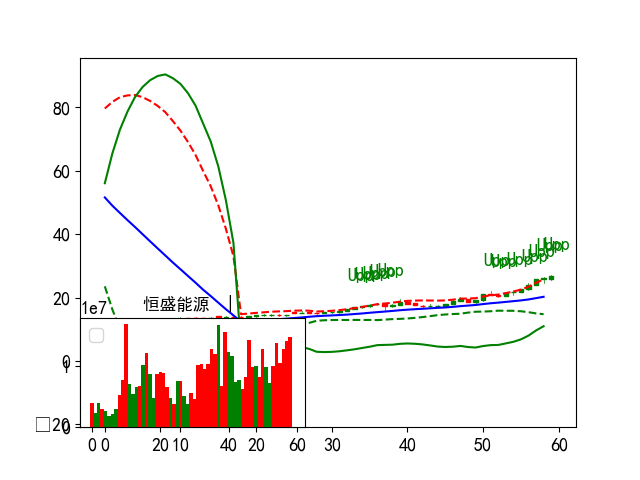

603516 0.0
xratio:1.79 ra_diff:nan
code: 603516


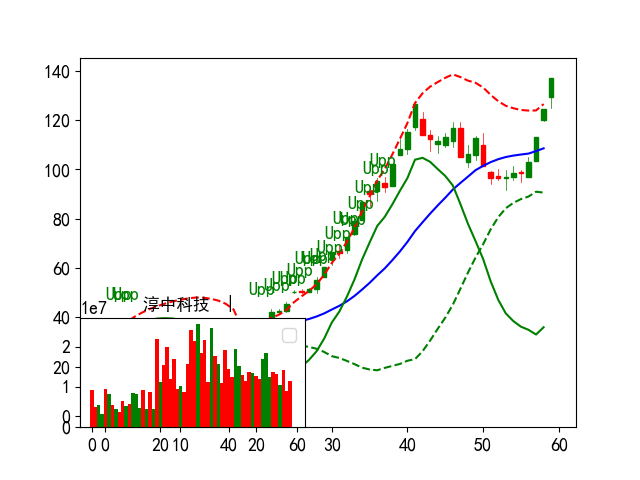

301448 0.0
xratio:0.48 ra_diff:nan
code: 301448


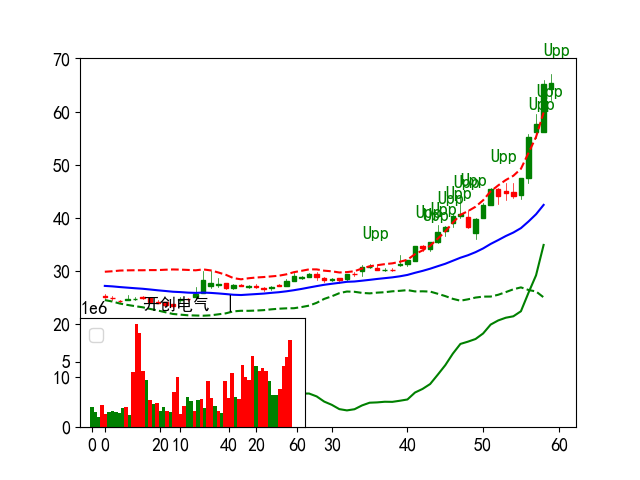

600243 0.0
xratio:0.04 ra_diff:nan
code: 600243


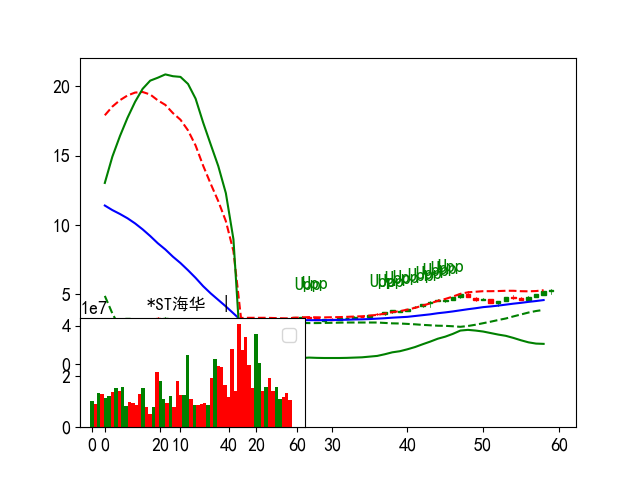

002058 0.0
xratio:0.12 ra_diff:nan
code: 002058


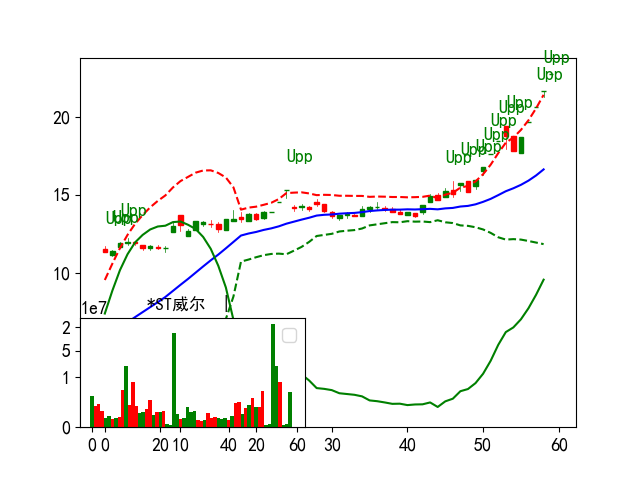

605287 0.0
xratio:0.07 ra_diff:nan
code: 605287


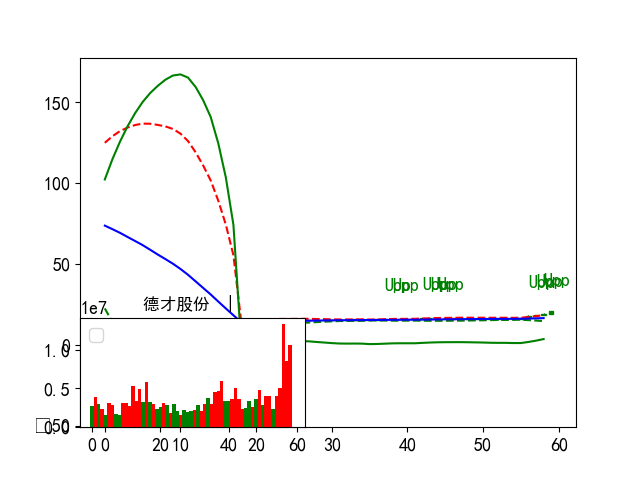

002602 0.0
xratio:0.13 ra_diff:nan
code: 002602


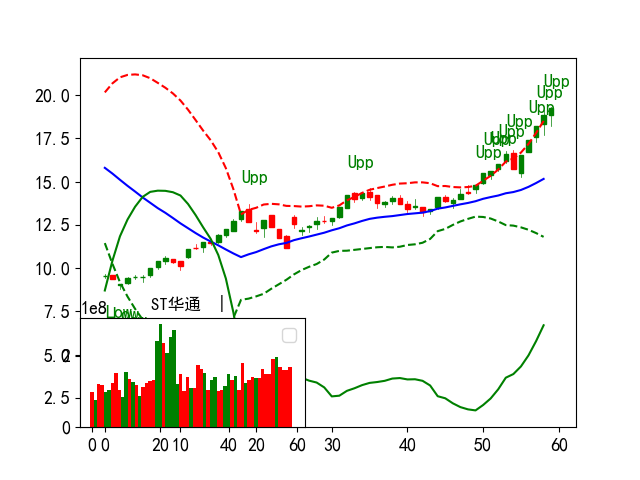

300716 0.0
xratio:0.08 ra_diff:nan
code: 300716


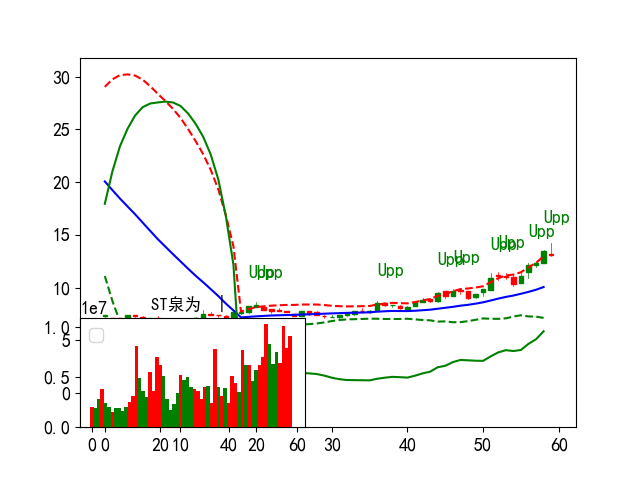

002364 0.0
xratio:0.23 ra_diff:nan
code: 002364


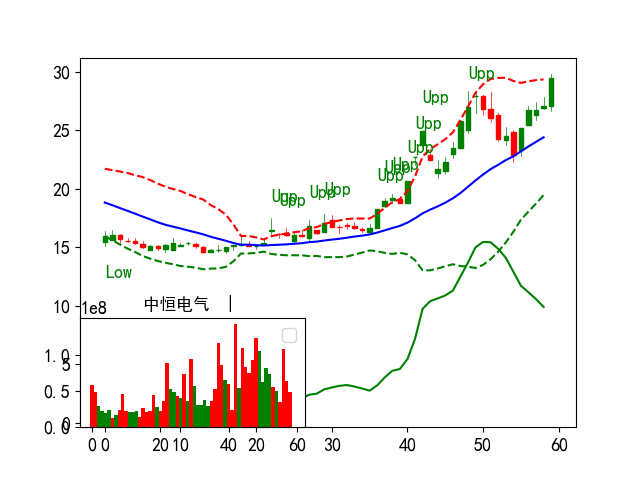

600103 0.0
xratio:0.01 ra_diff:nan
code: 600103


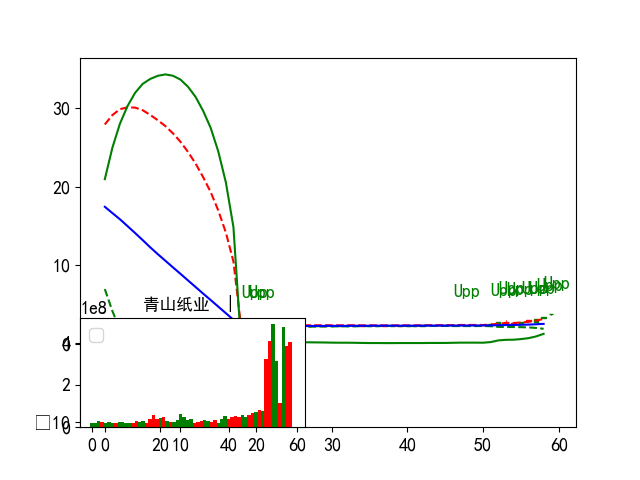

000980 0.0
xratio:0.02 ra_diff:nan
code: 000980


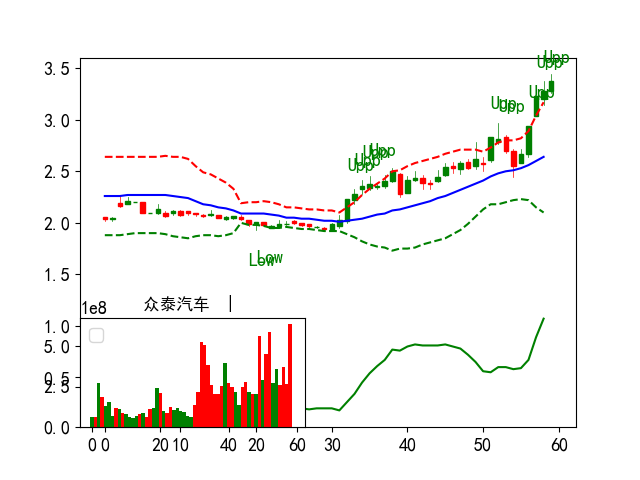

601598 0.0
xratio:0.02 ra_diff:nan
code: 601598


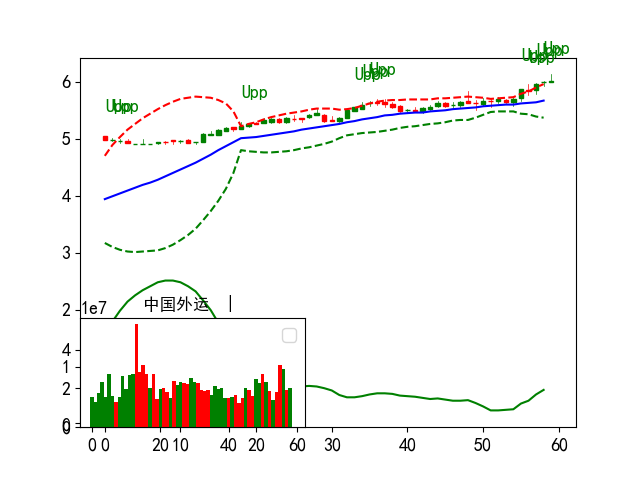

300857 0.0
xratio:0.51 ra_diff:nan
code: 300857


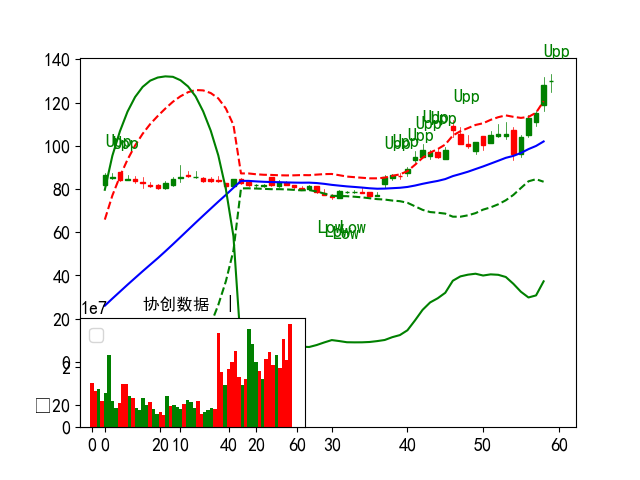

002759 0.0
xratio:0.08 ra_diff:nan
code: 002759


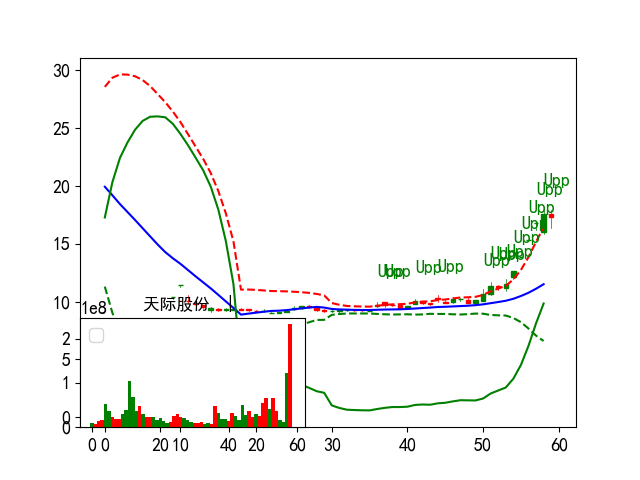

603101 0.0
xratio:0.07 ra_diff:nan
code: 603101


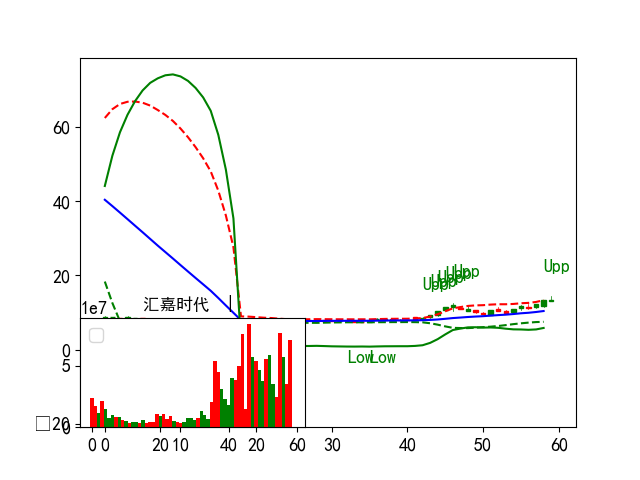

002115 0.0
xratio:0.05 ra_diff:nan
code: 002115


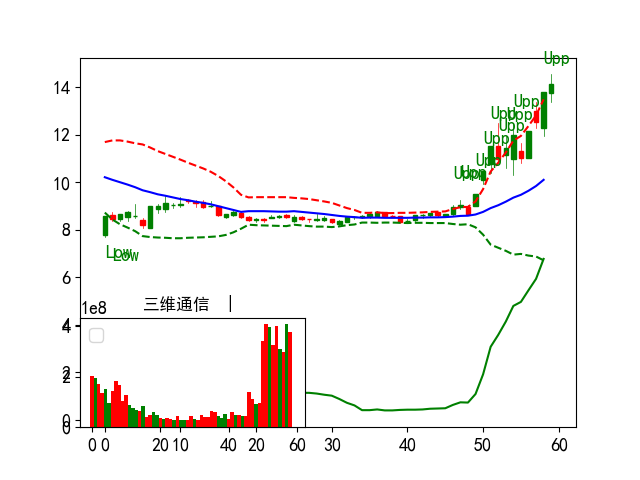

603100 0.0
xratio:0.03 ra_diff:nan
code: 603100


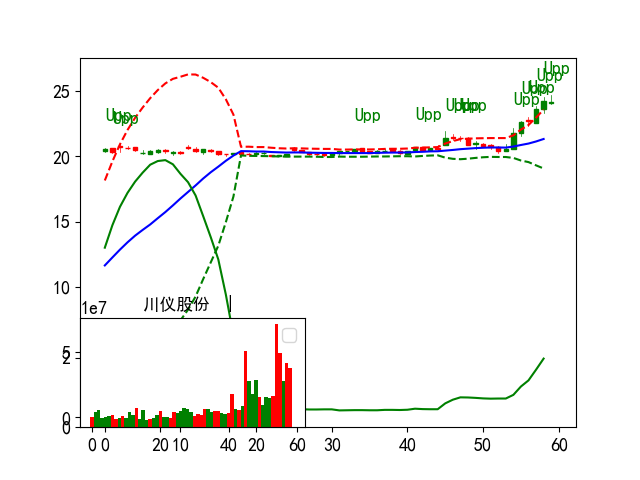

603222 0.0
xratio:0.11 ra_diff:nan
code: 603222


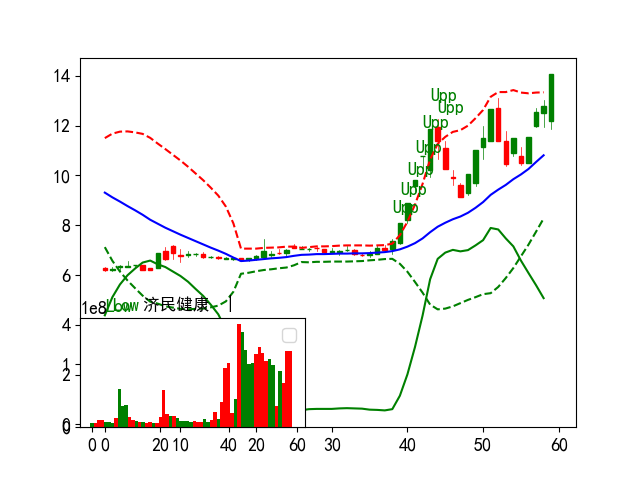

600601 0.0
xratio:0.08 ra_diff:nan
code: 600601


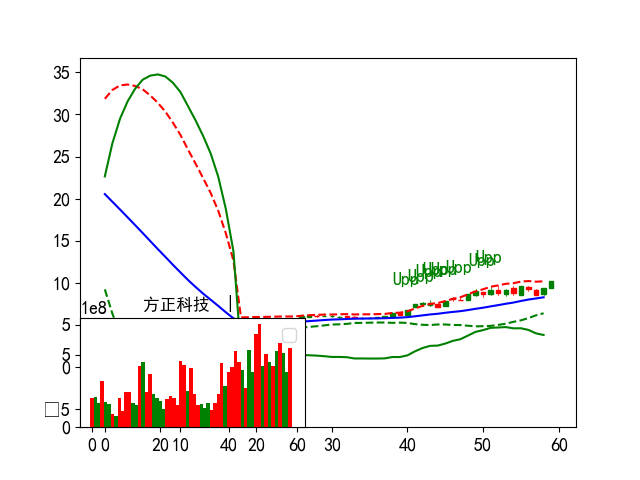

300692 0.0
xratio:0.02 ra_diff:nan
code: 300692


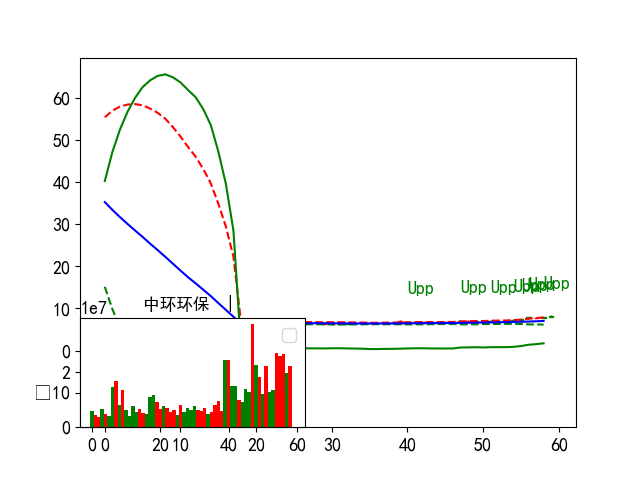

In [195]:
print("df_mask_hmax:%s"%(len(df_mask_hmax)))
for co in df_mask_hmax.index[:20]:
    print(co,dfs.loc[co].ra_diff[-1])
    show_ohlc_upper(dfsRoot.loc[co][-60:],code=co)

###  df_masklastd 068
    show_ohlc_upper(dfs.loc[co][-60:])

df_masklastd:97
920029 0.0
xratio:nan ra_diff:nan
code: 920029


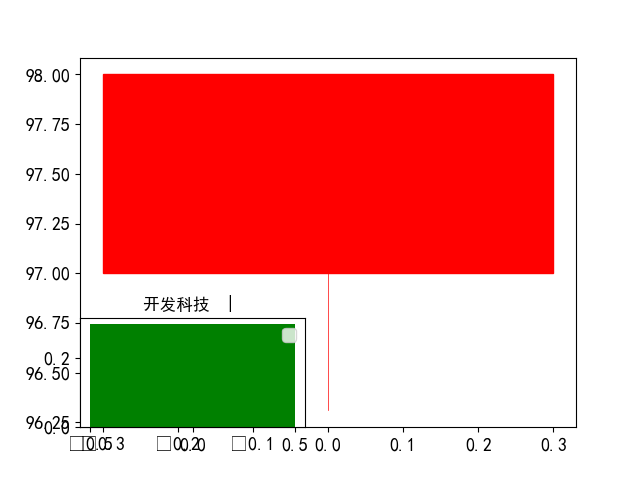

836239 0.0
xratio:nan ra_diff:nan
code: 836239


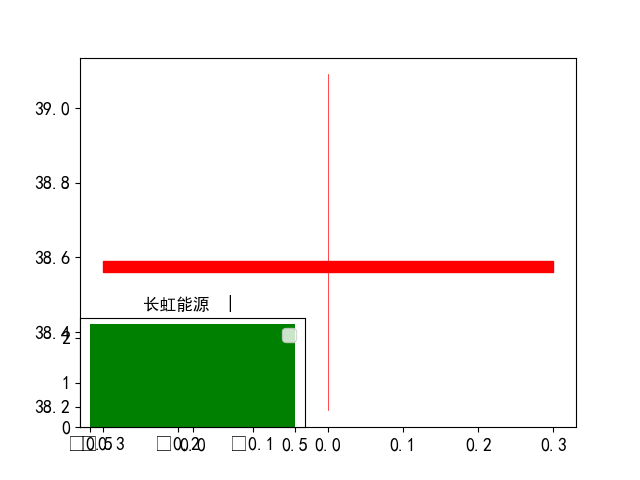

430476 0.0
xratio:nan ra_diff:nan
code: 430476


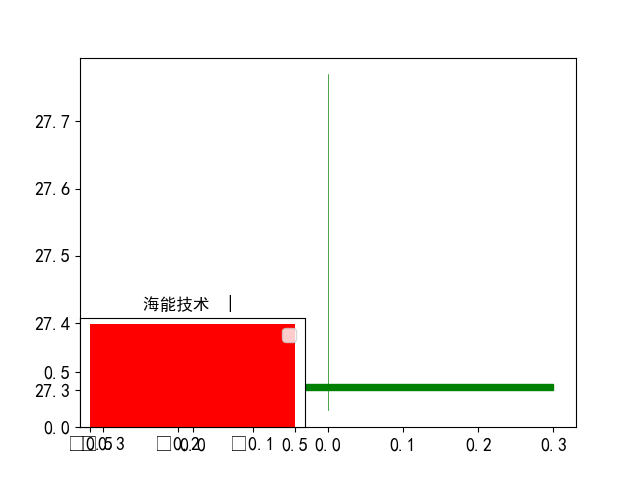

600376 0.0
xratio:0.02 ra_diff:nan
code: 600376


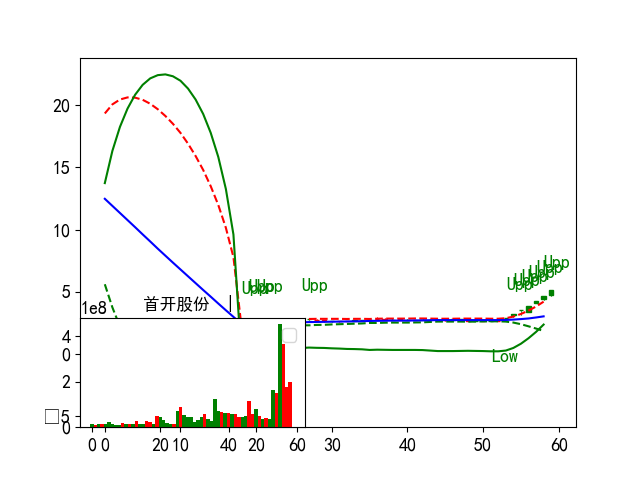

600103 0.0
xratio:0.01 ra_diff:nan
code: 600103


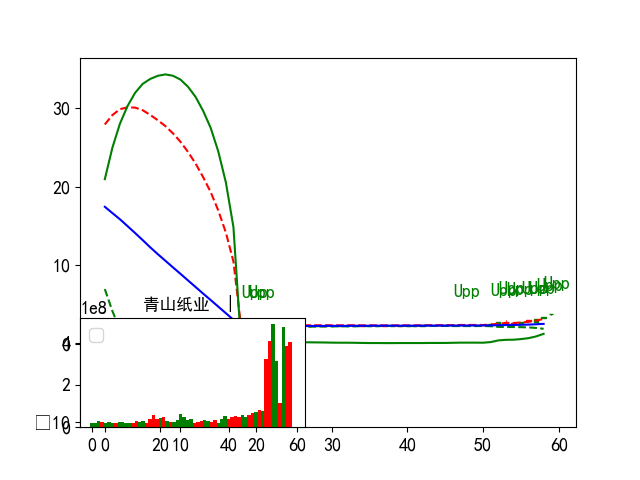

000718 0.0
xratio:0.0 ra_diff:nan
code: 000718


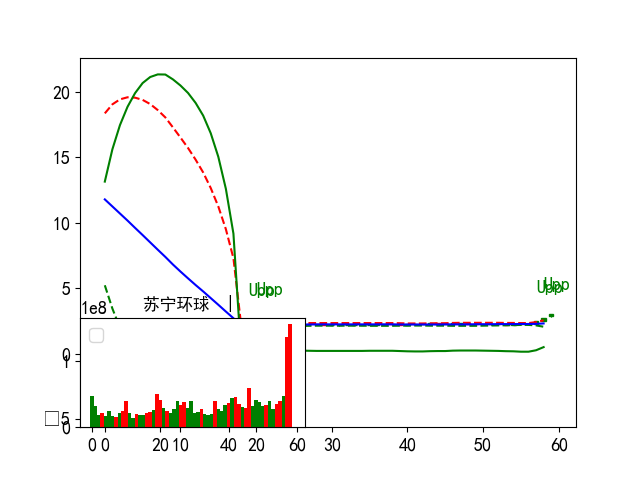

600173 0.0
xratio:0.02 ra_diff:nan
code: 600173


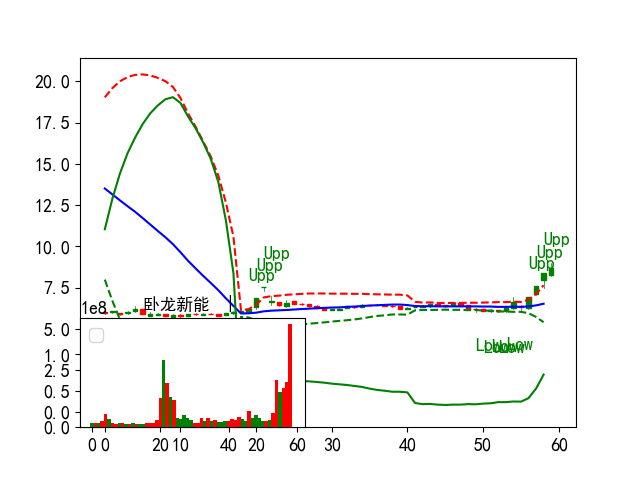

430425 0.0
xratio:nan ra_diff:nan
code: 430425


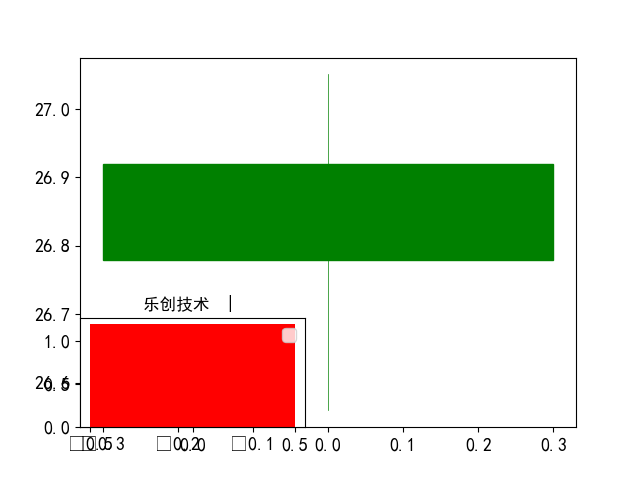

603978 0.0
xratio:0.02 ra_diff:nan
code: 603978


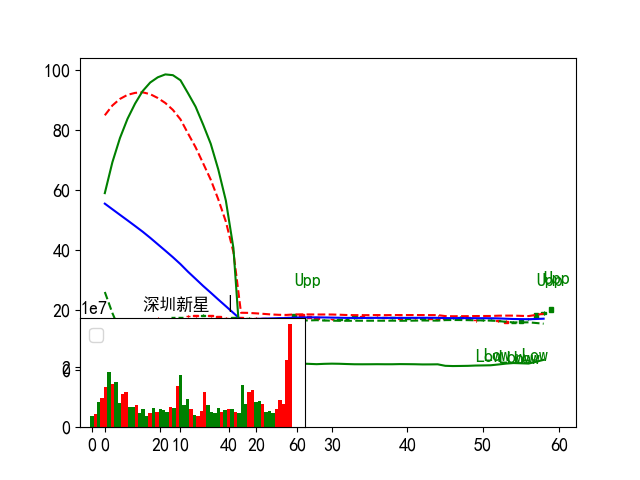

300472 0.0
xratio:0.07 ra_diff:nan
code: 300472


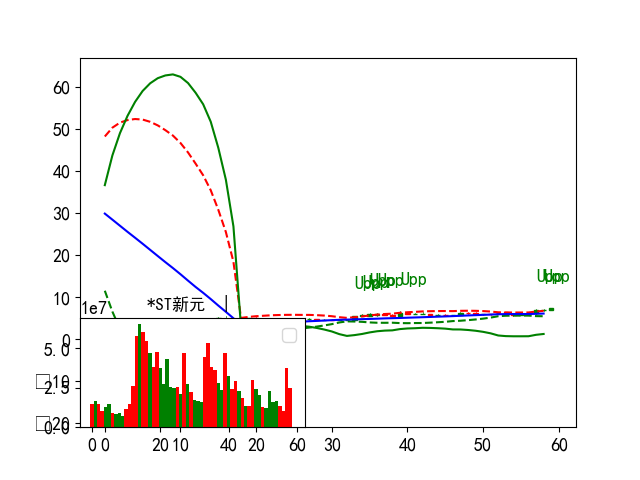

In [196]:
print("df_masklastd:%s"%(len(df_masklastd)))
for co in df_masklastd.index[:10]:
    print(co,dfs.loc[co].ra_diff[-1])
    show_ohlc_upper(dfsRoot.loc[co][-60:],code=co)

### Cross_hmax_250 068

In [197]:
# dfs.loc[code_t].ma5
cross_hmax_250 = [co for co in df_masklastd.index.get_level_values(
    'code') if co in df_mask_hmax.index.get_level_values('code')]
# df_mask250.loc[code_t]
print("cross_hamx:%s" % (len(cross_hmax_250)))
show_tdx_data(df_masklastd.loc[cross_hmax_250],limit=5)

cross_hamx:45
Count:45 41


name  couts       date   perc  ra_diff  xratio   idx  hat  close  \
code                                                                       
920029  开发科技      1 2025-09-11  -0.77      0.0    0.00  0.00  0.0  97.00   
836239  长虹能源      1 2025-09-11  -0.26      0.0    0.00  0.00  0.0  38.56   
430476  海能技术      1 2025-09-11   0.11      0.0    0.00  0.00  0.0  27.31   
600376  首开股份      1 2025-09-11  10.04      0.0    0.07  2.49  0.0   5.15   
600103  青山纸业      1 2025-09-11  10.14      0.0    0.04  1.45  0.0   3.80   

        volsum5d  ...  ma250  nclose   llow   vol1d   vol2d    vol3d   vol4d  \
code              ...                                                          
920029    3140.7  ...    0.0   96.88  96.31  -44.44  -92.20  3195.24  -84.56   
836239     582.1  ...    0.0   38.66  38.19  -53.97  546.15   -75.39   64.25   
430476     238.5  ...    0.0   27.47  27.27  -45.66   40.65   -48.54  298.33   
600376      45.3  ...    0.0    5.12   4.68 -100.00   12.81   -52.07  -19.23   
600103     141.3  ...    0.0    3.80   3.65 -100.00    5.81   -18.88  318.38   

         vol5d  perc3d  perc5d  
code                            
920029  166.67  204.46  350.53  
836239  101.04  137.73  142.52  
430476   -6.25  125.70   62.17  
600376  203.80   33.42   61.44  
600103  -64.03   33.33   52.61  

[5 rows x 24 columns]

df_mask250 cross_hmax_250:45
000926 0.0
xratio:0.02 ra_diff:nan
code: 000926


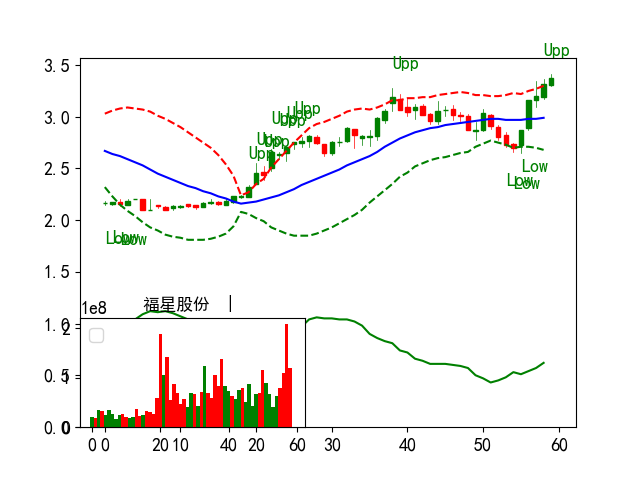

001225 0.0
xratio:0.13 ra_diff:nan
code: 001225


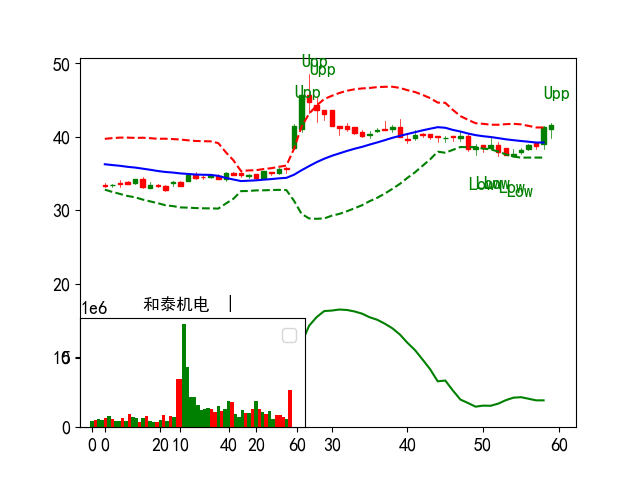

301045 0.0
xratio:0.08 ra_diff:nan
code: 301045


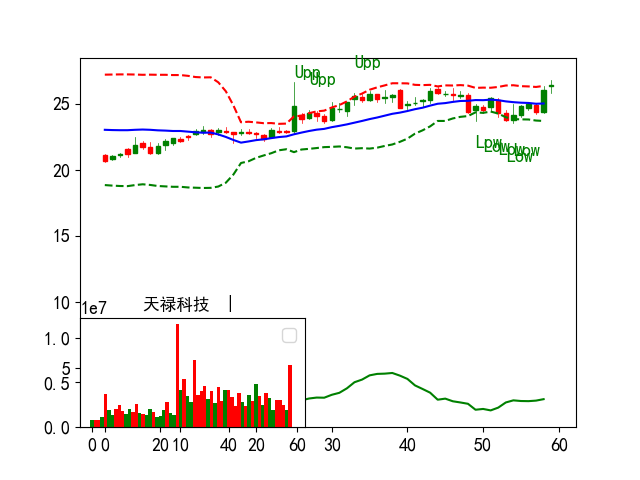

001300 0.0
xratio:0.0 ra_diff:nan
code: 001300


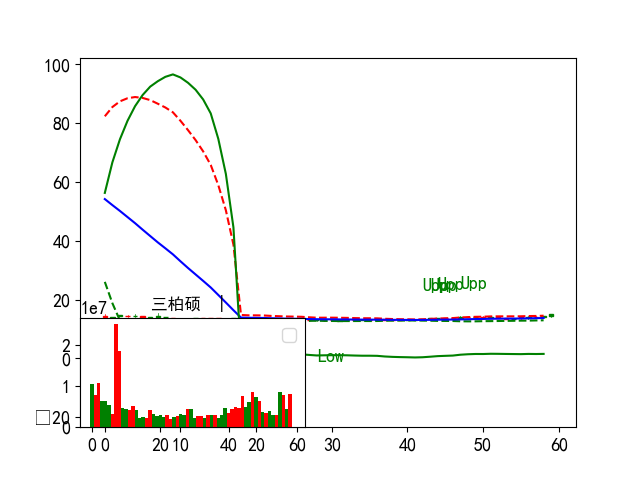

002106 0.0
xratio:0.03 ra_diff:nan
code: 002106


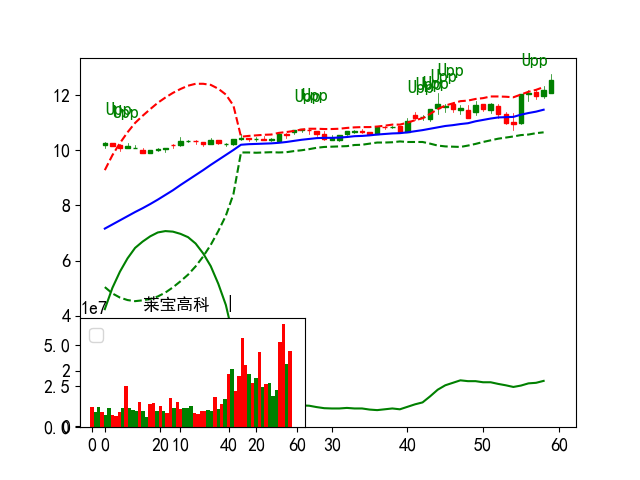

002064 0.0
xratio:0.03 ra_diff:nan
code: 002064


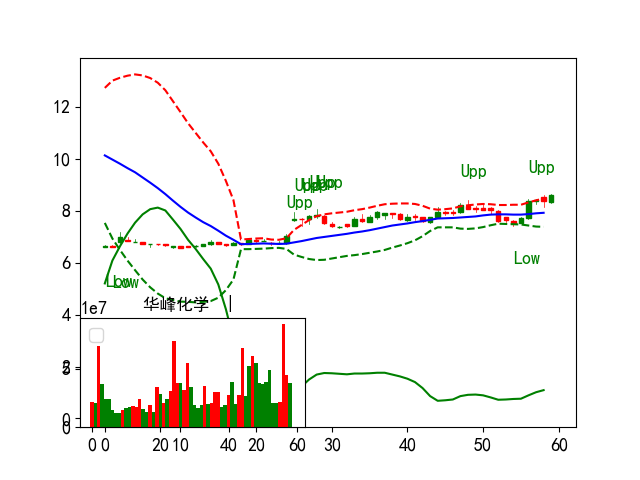

600975 0.0
xratio:0.01 ra_diff:nan
code: 600975


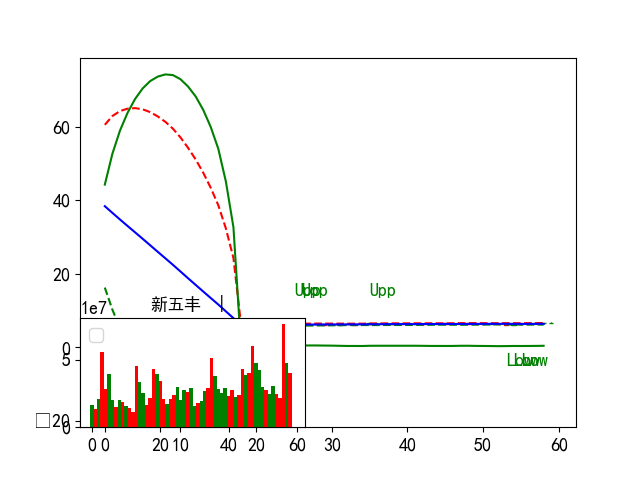

603477 0.0
xratio:-0.01 ra_diff:nan
code: 603477


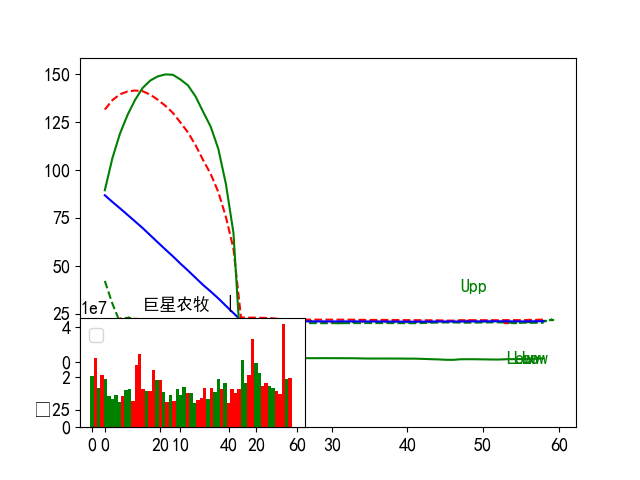

430478 0.0
xratio:nan ra_diff:nan
code: 430478


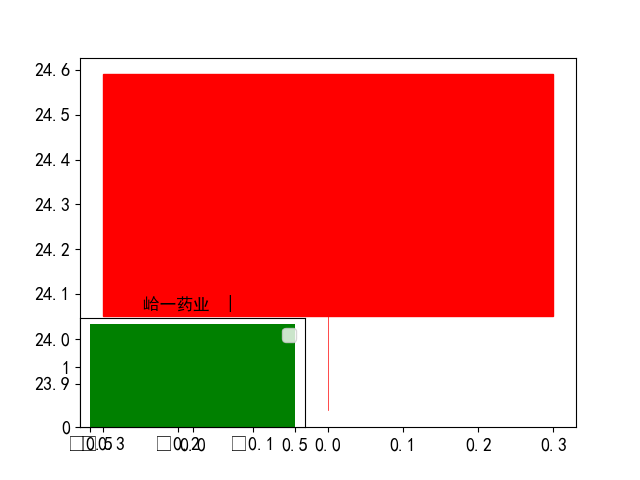

836504 0.0
xratio:nan ra_diff:nan
code: 836504


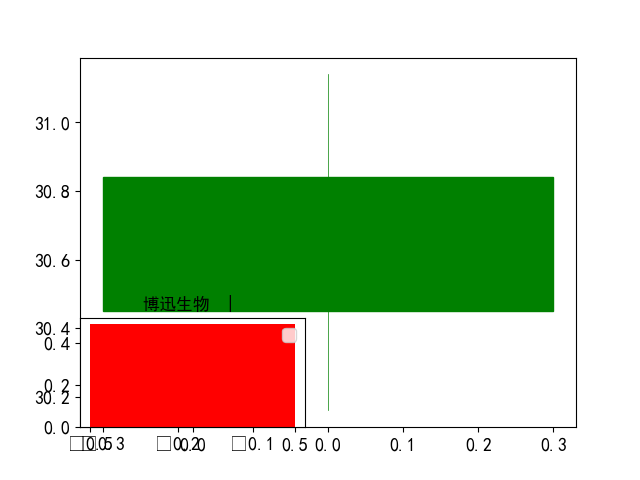

In [198]:
print("df_mask250 cross_hmax_250:%s"%(len(cross_hmax_250)))
# dfs.loc['000002'].shape
for co in cross_hmax_250[-10:]:
    print(co,dfs.loc[co].ra_diff[-1])
    show_ohlc_upper(dfsRoot.loc[co][-60:],code=co)

## 写入061

In [199]:
# write_code_to_blk(df_masklastd.index.tolist(),'061')
# hmax_code = df_mask_hmax[(df_mask_hmax.couts > 1) & (df_mask_hmax.volsum5d > 10) & (df_mask_hmax.volsum5d < 150)].index.tolist()
hmax_code = df_mask_hmax[(df_mask_hmax.couts > 1) ].index.tolist()
print(len(cross_hmax_250))
# write_code_to_blk(cross_hmax_250,'068')
# write_code_to_blk(hmax_code,'061')

45


In [200]:
# print(df_masklastd.loc['301255'].date)

# 默认年线筛选

In [201]:
top_temp.shape
top_temp.index

(492, 36)

Index(['605288', '600673', '600301', '300953', '603713', '399006', '688248',
       '603099', '601689', '301413',
       ...
       '605123', '600288', '600814', '002683', '603666', '603991', '603051',
       '002492', '002318', '688170'],
      dtype='object', name='code', length=492)

## plt.close('all')

In [202]:
# plt.close('all')

# 写入060